# Assign 6: Data Exploration and Machine Learning

**Question:** How is COVID-19 developing differently in the different American states?

Data:<br>
* [Johns Hopkins Reports](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports) 
* [US Population Distribution By Age](https://www.kff.org/other/state-indicator/distribution-by-age/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)
* [US Median Household Income](https://dqydj.com/average-income-by-state-median-top-percentiles/)
* [US State Populations](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population)
* [US Dates of Shelter in Place](https://www.nytimes.com/interactive/2020/us/states-reopen-map-coronavirus.html)

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
import math
from patsy import dmatrices
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, r2_score

### Read in and Preprocess data

In [3]:
# df = pd.read_csv('Combined_4_28.csv', parse_dates=['date'], index_col=['date']) # can't use this since I have duplicate dates
df = pd.read_csv('updated_csse_covid_daily_reports_us_05-03-2020.csv', parse_dates=['Date_of_10th_Case', 'Date_of_Shelter_in_Place']) # read in date column as type datetime

In [595]:
df.head()

Province_State Country_Region    Last_Update      Lat     Long_  Confirmed  \
0         Alabama             US  5/4/2020 2:32  32.3182  -86.9023       7888   
1          Alaska             US  5/4/2020 2:32  61.3707 -152.4044        368   
2  American Samoa             US  5/4/2020 2:32 -14.2710 -170.1320          0   
3         Arizona             US  5/4/2020 2:32  33.7298 -111.4312       8640   
4        Arkansas             US  5/4/2020 2:32  34.9697  -92.3731       3437   

   Deaths  Recovered  Active  FIPS           ...             Norm_Tested  \
0     290          0    7598     1           ...             1886.528858   
1       9        262      97     2           ...             2949.647664   
2       0          0       0    60           ...              102.767511   
3     362       1597    6681     4           ...             1114.468388   
4      76       1999    1362     5           ...             1752.598910   

   Norm_Hospitalized  Percent_Over_65  Median_Income  Reference_Date  \
0          21.108728               17          49396        5/3/2020   
1                NaN               12          68400        5/3/2020   
2                NaN                5          23892        5/3/2020   
3          18.519747               18          62311        5/3/2020   
4          14.149362               17          49778        5/3/2020   

  Date_of_10th_Case  Days_since_10th_case  Date_of_Shelter_in_Place  \
0        2020-03-15                    49                2020-04-04   
1        2020-03-20                    44                2020-03-28   
2               NaT                     0                       NaT   
3        2020-03-14                    50                2020-03-31   
4        2020-03-14                    50                       NaT   

   Days_Since_Shelter_in_Place  Days_Between_Case10_SIP  
0                           29                       20  
1                           36                        8  
2                            0                        0  
3                           33                       17  
4                            0                       50  

[5 rows x 33 columns]

In [596]:
df.tail()

Province_State Country_Region    Last_Update      Lat     Long_  Confirmed  \
51       Virginia             US  5/4/2020 2:32  37.7693  -78.1700      18672   
52     Washington             US  5/4/2020 2:32  47.4009 -121.4905      15185   
53  West Virginia             US  5/4/2020 2:32  38.4912  -80.9545       1195   
54      Wisconsin             US  5/4/2020 2:32  44.2685  -89.6165       7964   
55        Wyoming             US  5/4/2020 2:32  42.7560 -107.3025        586   

    Deaths  Recovered  Active  FIPS           ...             Norm_Tested  \
51     660       2497   15515    51           ...             1265.324346   
52     834          0   14351    53           ...             2722.493934   
53      48        611     536    54           ...             2881.348461   
54     339       3723    3902    55           ...             1476.375688   
55       7        391     188    56           ...             1765.674486   

    Norm_Hospitalized  Percent_Over_65  Median_Income  Reference_Date  \
51          45.808579               16          76786        5/3/2020   
52                NaN               16          79801        5/3/2020   
53                NaN               20          50180        5/3/2020   
54          27.617316               17          62676        5/3/2020   
55          10.367009               17          62002        5/3/2020   

   Date_of_10th_Case  Days_since_10th_case  Date_of_Shelter_in_Place  \
51        2020-03-12                    52                2020-03-30   
52        2020-03-01                    63                2020-03-23   
53        2020-03-21                    43                2020-03-24   
54        2020-03-13                    51                2020-03-25   
55        2020-03-17                    47                       NaT   

    Days_Since_Shelter_in_Place  Days_Between_Case10_SIP  
51                           34                       18  
52                           41                       22  
53                           40                        3  
54                           39                       12  
55                            0                       47  

[5 rows x 33 columns]

In [597]:
df.describe()

Lat       Long_      Confirmed        Deaths     Recovered  \
count  56.000000   56.000000      56.000000     56.000000     56.000000   
mean   36.840089  -85.206614   20676.571429   1208.553571   3217.000000   
std    10.887035   49.754449   46034.883677   3473.884726   8621.481965   
min   -14.271000 -170.132000       0.000000      0.000000      0.000000   
25%    34.594600 -101.165775    2403.750000     62.250000      0.000000   
50%    39.061850  -87.944200    6644.500000    255.500000    638.500000   
75%    42.361650  -76.970625   19918.750000    918.250000   2524.500000   
max    61.370700  145.673900  316415.000000  24708.000000  58950.000000   

              Active       FIPS  Incident_Rate  People_Tested  \
count      56.000000  56.000000      56.000000      56.000000   
mean    16251.017857  32.535714     301.609599  125952.964286   
std     35322.502501  19.075891     344.426612  173849.212338   
min         0.000000   1.000000       0.000000      57.000000   
25%      1035.250000  17.750000     118.695333   29453.500000   
50%      4412.500000  31.500000     179.396103   73435.500000   
75%     15530.250000  46.250000     351.952996  145417.750000   
max    232757.000000  78.000000    1876.605960  985911.000000   

       People_Hospitalized           ...             Norm_Deaths  \
count            32.000000           ...               56.000000   
mean           3931.125000           ...               14.453164   
std           12021.209356           ...               23.155600   
min              60.000000           ...                0.000000   
25%             389.500000           ...                3.229190   
50%            1072.500000           ...                5.873203   
75%            3037.000000           ...               12.018927   
max           68736.000000           ...              127.010165   

       Norm_Recovered  Norm_Active  Norm_Tested  Norm_Hospitalized  \
count       56.000000    56.000000    56.000000          32.000000   
mean        58.352059   209.325336  2183.894786          45.646848   
std         73.449965   269.883948  1169.310330          69.262331   
min          0.000000     0.000000   102.767511           5.085205   
25%          0.000000    51.035684  1449.933228          14.171005   
50%         38.970094   131.083872  1845.591512          21.409517   
75%         70.485341   232.032148  2718.399791          44.162201   
max        372.204060  1196.475031  6789.659049         353.333767   

       Percent_Over_65  Median_Income  Days_since_10th_case  \
count        56.000000      56.000000             56.000000   
mean         16.053571   61171.482143             49.464286   
std           3.164690   14373.186917              9.087382   
min           5.000000   19958.000000              0.000000   
25%          15.750000   54562.250000             47.750000   
50%          16.000000   61951.000000             51.000000   
75%          18.000000   69883.000000             53.000000   
max          21.000000   86651.000000             72.000000   

       Days_Since_Shelter_in_Place  Days_Between_Case10_SIP  
count                    56.000000                56.000000  
mean                     28.964286                20.500000  
std                      15.097217                13.741774  
min                       0.000000                 0.000000  
25%                      28.750000                11.000000  
50%                      34.000000                16.500000  
75%                      40.000000                25.000000  
max                      45.000000                53.000000  

[8 rows x 26 columns]

In [598]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 33 columns):
Province_State                 56 non-null object
Country_Region                 56 non-null object
Last_Update                    56 non-null object
Lat                            56 non-null float64
Long_                          56 non-null float64
Confirmed                      56 non-null int64
Deaths                         56 non-null int64
Recovered                      56 non-null int64
Active                         56 non-null int64
FIPS                           56 non-null int64
Incident_Rate                  56 non-null float64
People_Tested                  56 non-null int64
People_Hospitalized            32 non-null float64
Mortality_Rate                 55 non-null float64
UID                            56 non-null int64
ISO3                           56 non-null object
Testing_Rate                   56 non-null float64
Hospitalization_Rate           32 non-null float

In [347]:
# df.rename(columns={'Days_Since_Shelter_in _Place': 'Days_Since_Shelter_in_Place'}, inplace=True)

In [4]:
df2 = df.copy(deep=True)

Drop unnecessary variables.

In [5]:
df2 = df2.drop(['Country_Region', 'Last_Update', 'FIPS', 'UID', 'ISO3', 'Reference_Date'], axis = 1) 

In [601]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 27 columns):
Province_State                 56 non-null object
Lat                            56 non-null float64
Long_                          56 non-null float64
Confirmed                      56 non-null int64
Deaths                         56 non-null int64
Recovered                      56 non-null int64
Active                         56 non-null int64
Incident_Rate                  56 non-null float64
People_Tested                  56 non-null int64
People_Hospitalized            32 non-null float64
Mortality_Rate                 55 non-null float64
Testing_Rate                   56 non-null float64
Hospitalization_Rate           32 non-null float64
Population                     56 non-null int64
Norm_Confirmed                 56 non-null float64
Norm_Deaths                    56 non-null float64
Norm_Recovered                 56 non-null float64
Norm_Active                    56 non-null 

Change int variables to float so all data is same type for machine learning

In [6]:
df2.loc[:,'Confirmed':'Median_Income'] = df2.loc[:,'Confirmed':'Median_Income'].astype(float)
df2.loc[:,'Days_since_10th_case'] = df2.loc[:,'Days_since_10th_case'].astype(float)
df2.loc[:,'Days_Since_Shelter_in_Place':] = df2.loc[:,'Days_Since_Shelter_in_Place':].astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 27 columns):
Province_State                 56 non-null object
Lat                            56 non-null float64
Long_                          56 non-null float64
Confirmed                      56 non-null float64
Deaths                         56 non-null float64
Recovered                      56 non-null float64
Active                         56 non-null float64
Incident_Rate                  56 non-null float64
People_Tested                  56 non-null float64
People_Hospitalized            32 non-null float64
Mortality_Rate                 55 non-null float64
Testing_Rate                   56 non-null float64
Hospitalization_Rate           32 non-null float64
Population                     56 non-null float64
Norm_Confirmed                 56 non-null float64
Norm_Deaths                    56 non-null float64
Norm_Recovered                 56 non-null float64
Norm_Active                    

In [7]:
(df2.isnull().sum() / 56 * 100).round(2) # Percent of null values per column 

Province_State                  0.00
Lat                             0.00
Long_                           0.00
Confirmed                       0.00
Deaths                          0.00
Recovered                       0.00
Active                          0.00
Incident_Rate                   0.00
People_Tested                   0.00
People_Hospitalized            42.86
Mortality_Rate                  1.79
Testing_Rate                    0.00
Hospitalization_Rate           42.86
Population                      0.00
Norm_Confirmed                  0.00
Norm_Deaths                     0.00
Norm_Recovered                  0.00
Norm_Active                     0.00
Norm_Tested                     0.00
Norm_Hospitalized              42.86
Percent_Over_65                 0.00
Median_Income                   0.00
Date_of_10th_Case               1.79
Days_since_10th_case            0.00
Date_of_Shelter_in_Place       19.64
Days_Since_Shelter_in_Place     0.00
Days_Between_Case10_SIP         0.00
d

In [8]:
# Drop hospitalization variables since they have many NAs
df2 = df2.drop(['People_Hospitalized', 'Hospitalization_Rate', 'Norm_Hospitalized'], axis = 1) 

### Correlation

In [605]:
# correlation matrix
df2.corr()

Lat     Long_  Confirmed    Deaths  \
Lat                          1.000000 -0.278274   0.113103  0.110928   
Long_                       -0.278274  1.000000   0.018328  0.029714   
Confirmed                    0.113103  0.018328   1.000000  0.987483   
Deaths                       0.110928  0.029714   0.987483  1.000000   
Recovered                    0.078943  0.007286   0.877623  0.910596   
Active                       0.117227  0.019186   0.991948  0.966355   
Incident_Rate                0.226613  0.043446   0.817831  0.808202   
People_Tested                0.093788 -0.069581   0.845466  0.786800   
Mortality_Rate              -0.252694  0.483884   0.297132  0.328803   
Testing_Rate                 0.368088  0.041801   0.387542  0.400633   
Population                   0.033591 -0.116133   0.480262  0.383528   
Norm_Confirmed               0.216771  0.050703   0.780502  0.764432   
Norm_Deaths                  0.164480  0.069016   0.851443  0.856589   
Norm_Recovered               0.113294  0.052242   0.454719  0.500887   
Norm_Active                  0.216597  0.041036   0.744900  0.712505   
Norm_Tested                  0.327439  0.078668   0.386492  0.390486   
Percent_Over_65              0.413408 -0.318263   0.007186  0.011940   
Median_Income                0.654859 -0.317463   0.197704  0.161993   
Days_since_10th_case         0.632199 -0.138799   0.325791  0.265649   
Days_Since_Shelter_in_Place  0.322373 -0.248109   0.277176  0.248589   
Days_Between_Case10_SIP      0.063900  0.180794  -0.089071 -0.097436   

                             Recovered    Active  Incident_Rate  \
Lat                           0.078943  0.117227       0.226613   
Long_                         0.007286  0.019186       0.043446   
Confirmed                     0.877623  0.991948       0.817831   
Deaths                        0.910596  0.966355       0.808202   
Recovered                     1.000000  0.810149       0.708473   
Active                        0.810149  1.000000       0.813449   
Incident_Rate                 0.708473  0.813449       1.000000   
People_Tested                 0.690975  0.855842       0.571529   
Mortality_Rate                0.279782  0.286581       0.279548   
Testing_Rate                  0.380259  0.372858       0.589634   
Population                    0.335195  0.506379       0.184862   
Norm_Confirmed                0.656080  0.781892       0.995139   
Norm_Deaths                   0.762727  0.839254       0.958676   
Norm_Recovered                0.694975  0.373733       0.579455   
Norm_Active                   0.537006  0.769663       0.960720   
Norm_Tested                   0.351513  0.379504       0.632016   
Percent_Over_65              -0.024665  0.014211       0.034242   
Median_Income                 0.065808  0.225669       0.352776   
Days_since_10th_case          0.213052  0.346468       0.301728   
Days_Since_Shelter_in_Place   0.182330  0.292285       0.280584   
Days_Between_Case10_SIP      -0.059424 -0.091997      -0.108728   

                             People_Tested  Mortality_Rate  Testing_Rate  \
Lat                               0.093788       -0.252694      0.368088   
Long_                            -0.069581        0.483884      0.041801   
Confirmed                         0.845466        0.297132      0.387542   
Deaths                            0.786800        0.328803      0.400633   
Recovered                         0.690975        0.279782      0.380259   
Active                            0.855842        0.286581      0.372858   
Incident_Rate                     0.571529        0.279548      0.589634   
People_Tested                     1.000000        0.180916      0.296458   
Mortality_Rate                    0.180916        1.000000      0.008259   
Testing_Rate                      0.296458        0.008259      1.000000   
Population                        0.837269        0.063224     -0.052629   
Norm_Confirmed                    0.540538        0.284983    

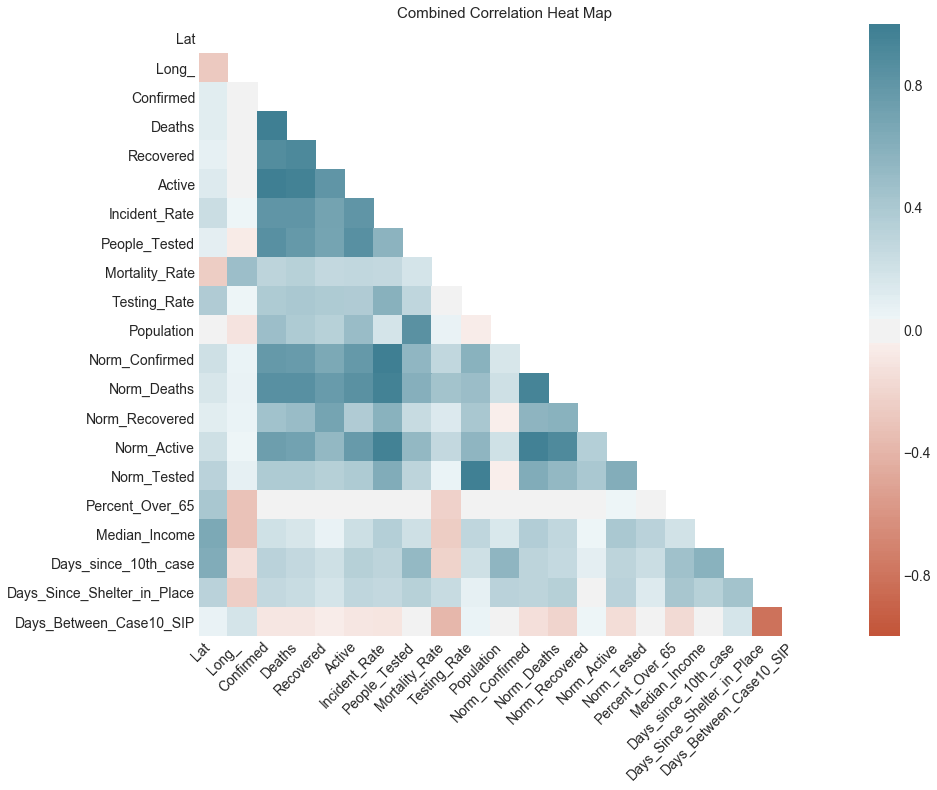

In [606]:
corr = df2.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, mask=mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Combined Correlation Heat Map', fontsize=15)
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

Confirmed Cases and Deaths seem to be important variables, as they arehighly correlated with many of the other variables. 

### Univariate Distributions of Key Variables.

In [356]:
%matplotlib inline

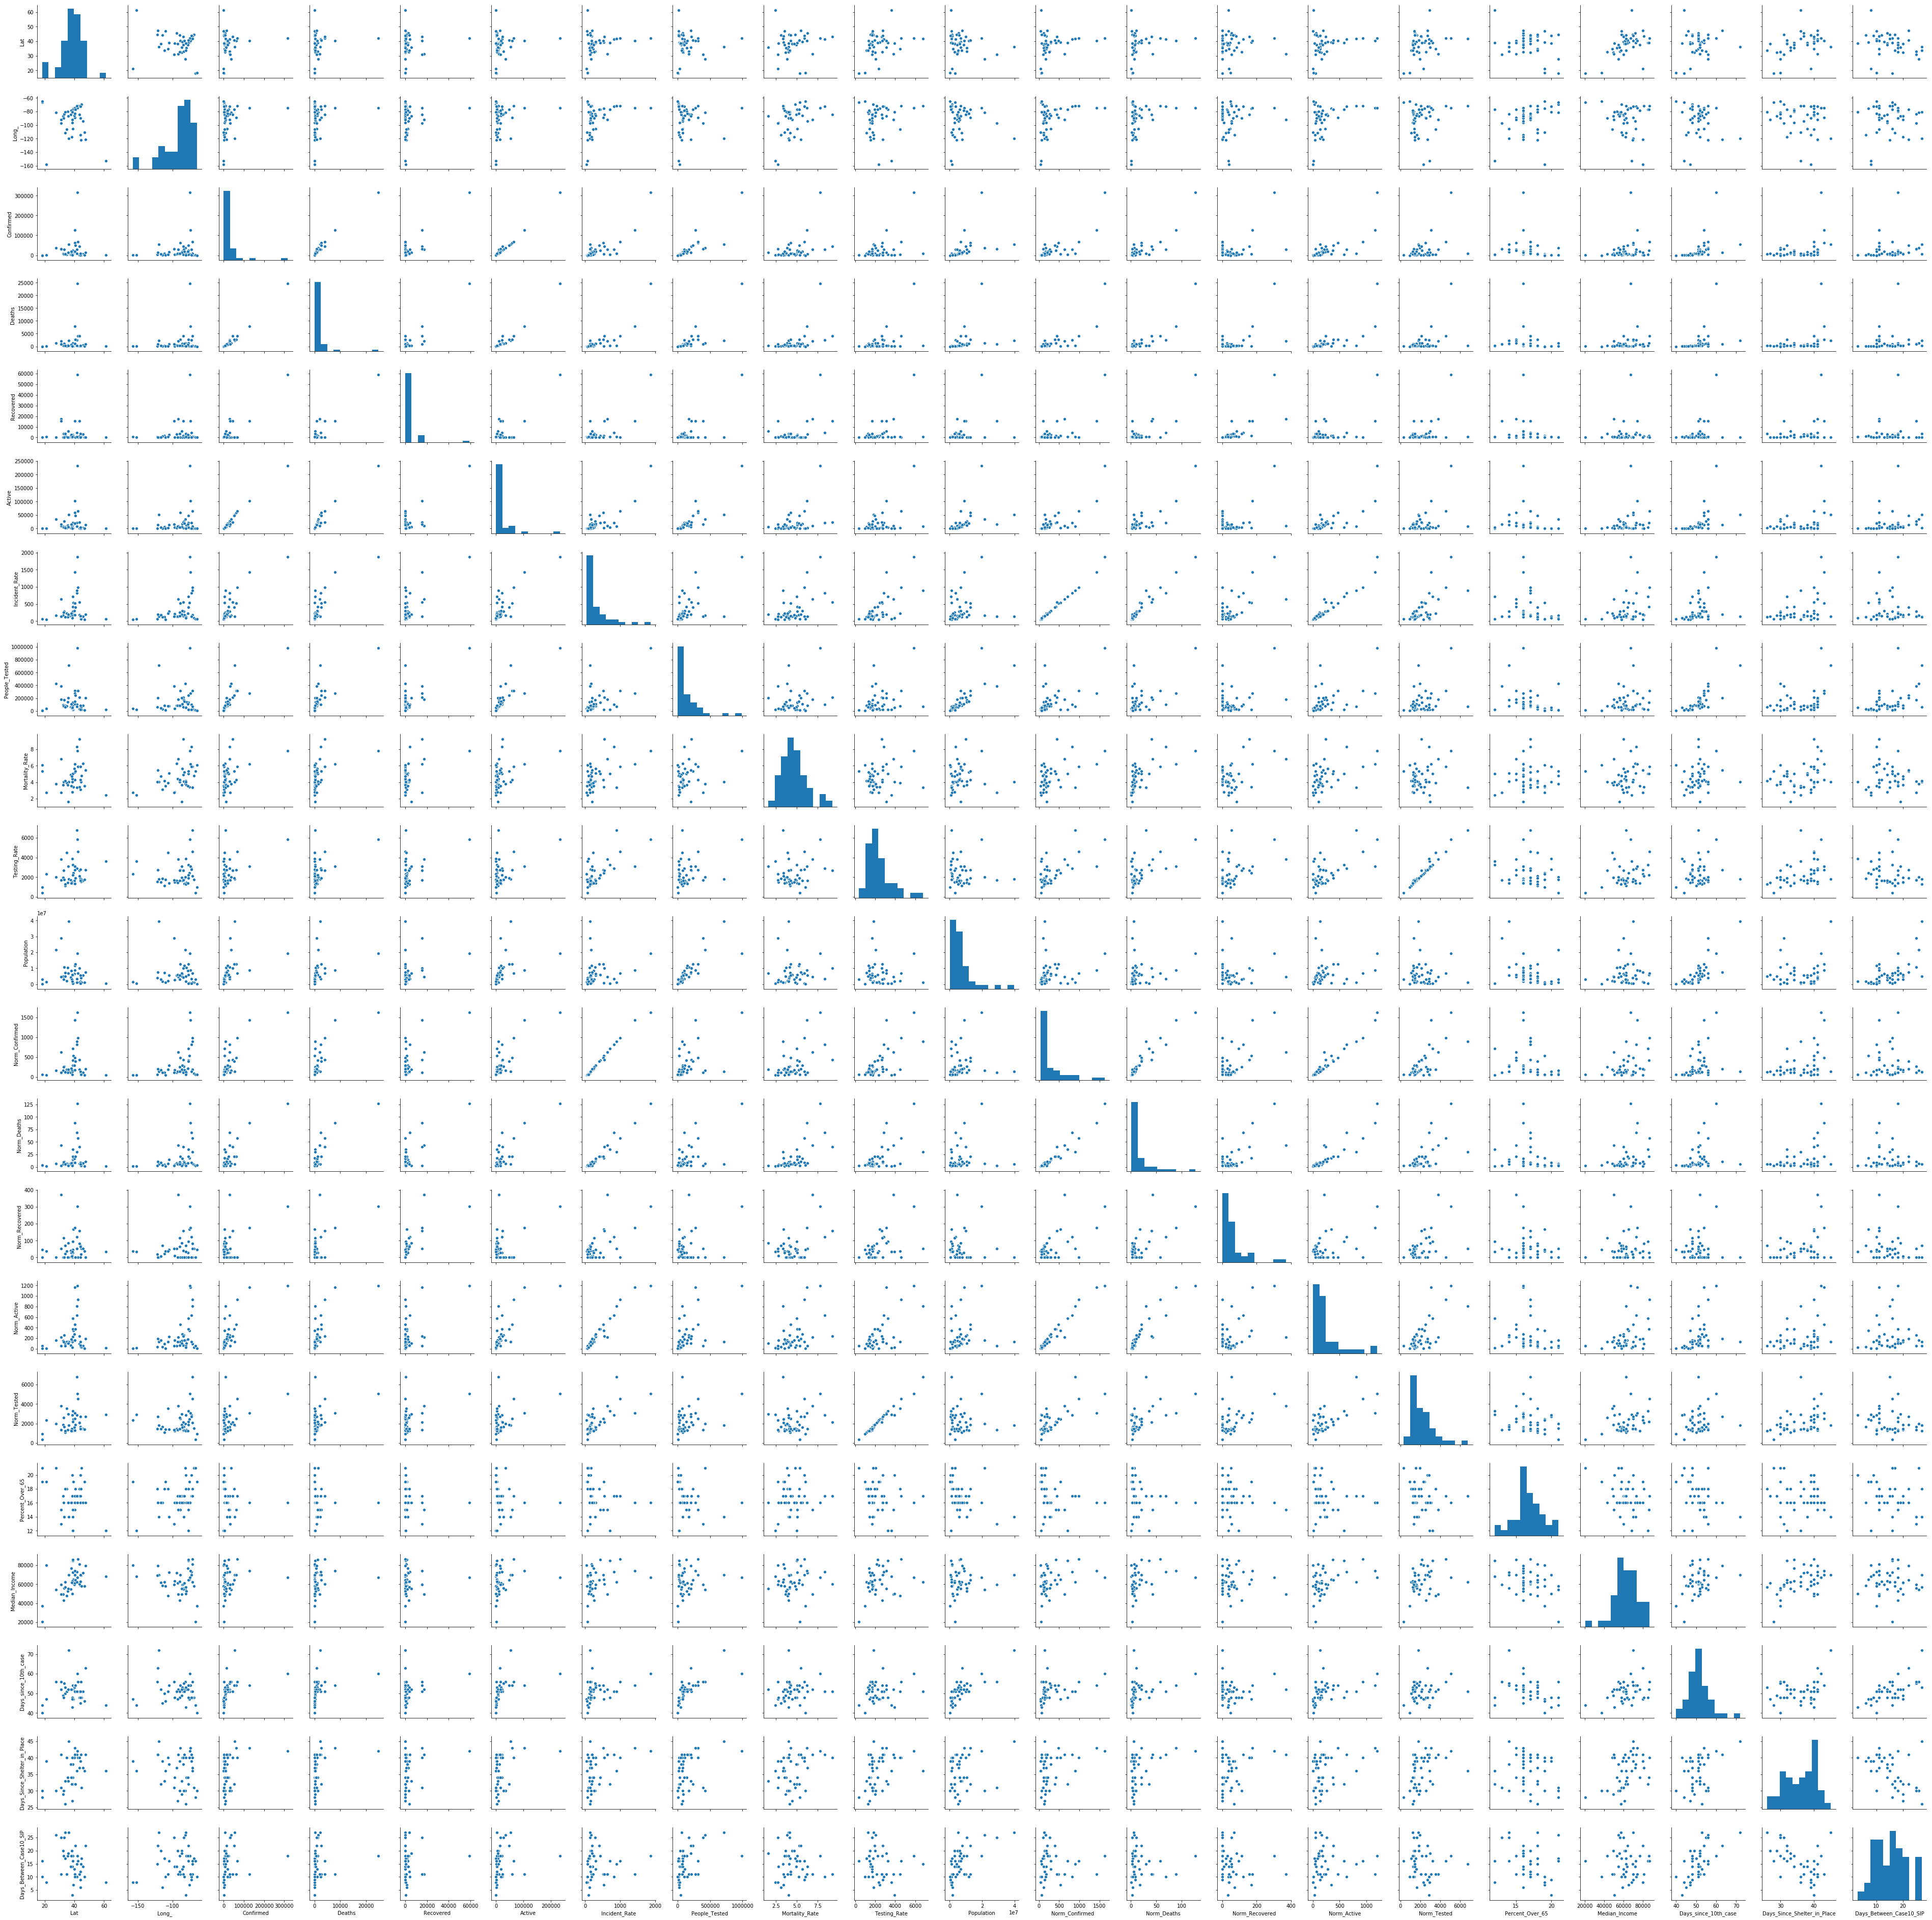

In [357]:
plot_df = df2.dropna()
# sns.pairplot(plot_df.loc[:,'confirmed':]) 

sns.pairplot(plot_df) 

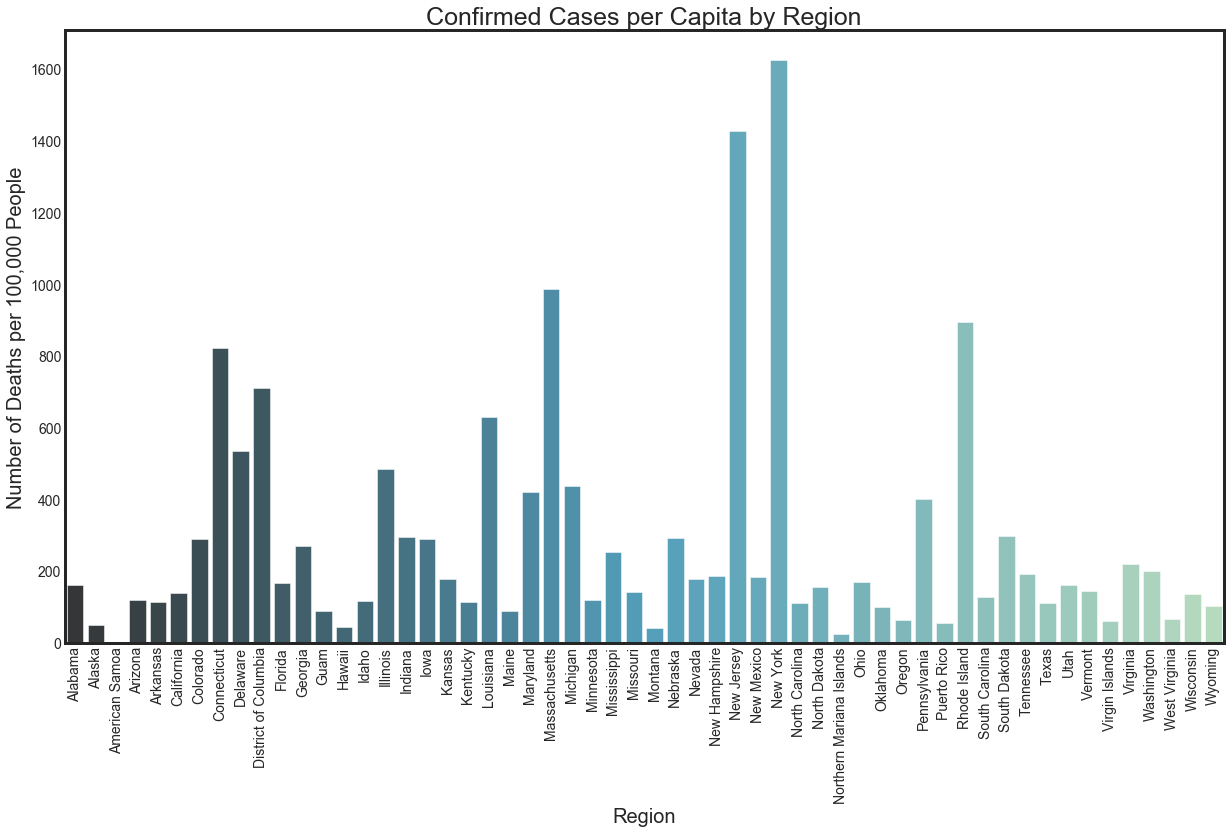

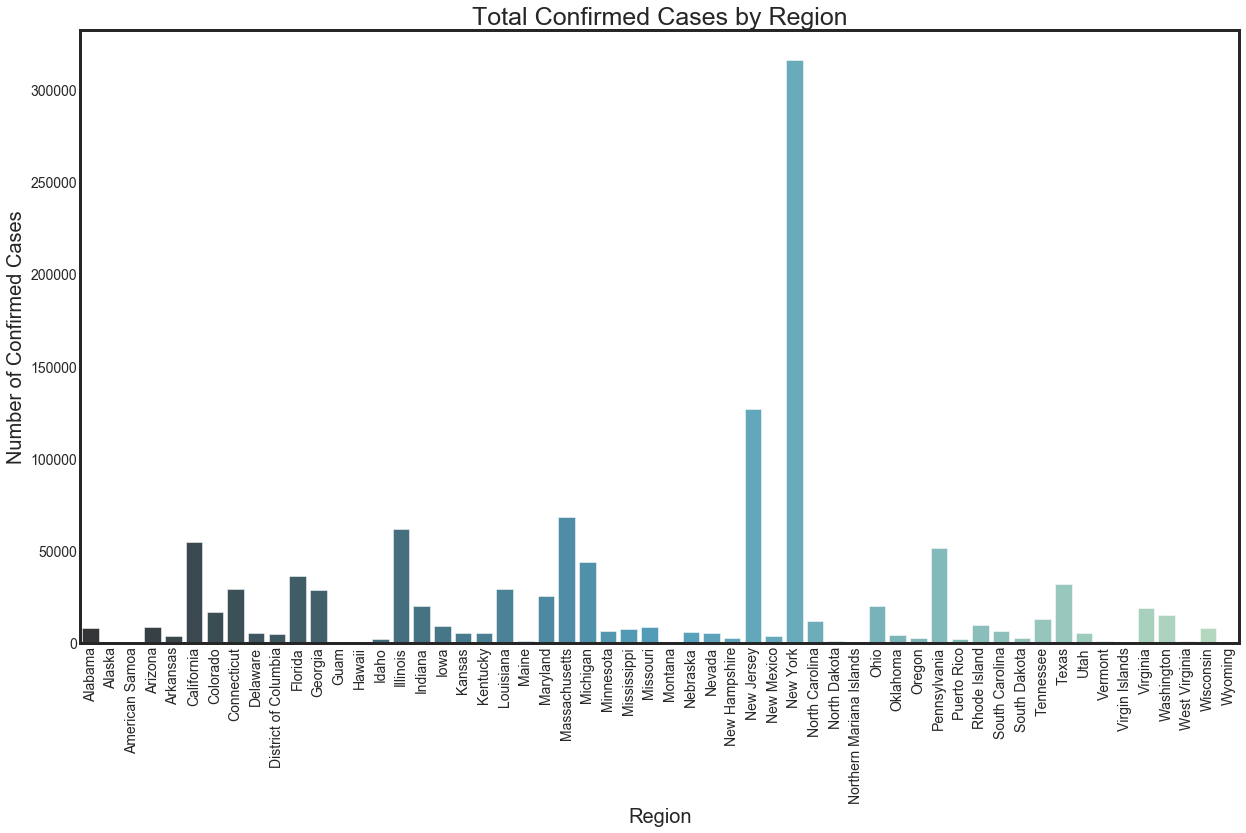

In [607]:
sns.barplot(x="Province_State", y="Norm_Confirmed", data=df2, palette="GnBu_d")
plt.title('Confirmed Cases per Capita by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Number of Deaths per 100,000 People', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

sns.barplot(x="Province_State", y="Confirmed", data=df2, palette="GnBu_d")
plt.title('Total Confirmed Cases by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Number of Confirmed Cases', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

New York is the clear leader, both in total confirmed cases and confirmed cases per capita. New Jersey has the second most confirmed cases per capita, likely due to its geographical proximity to New York.

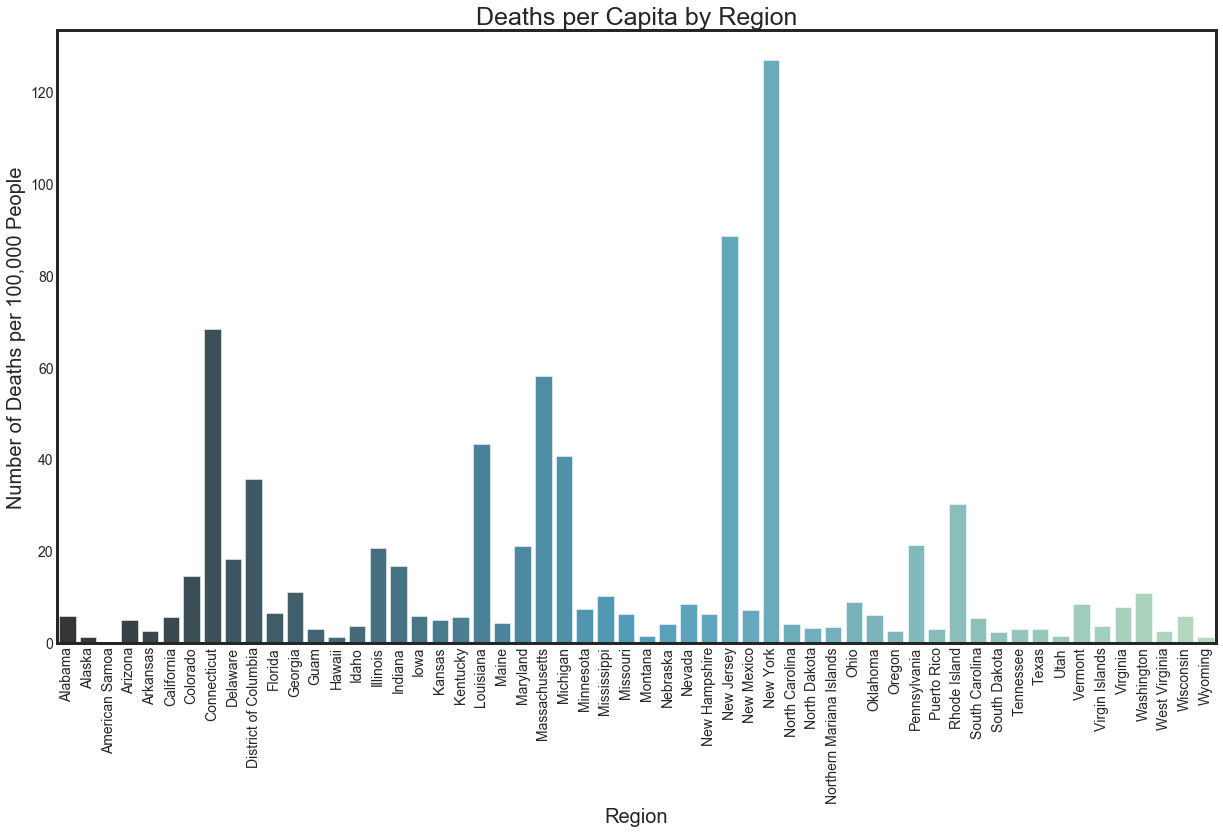

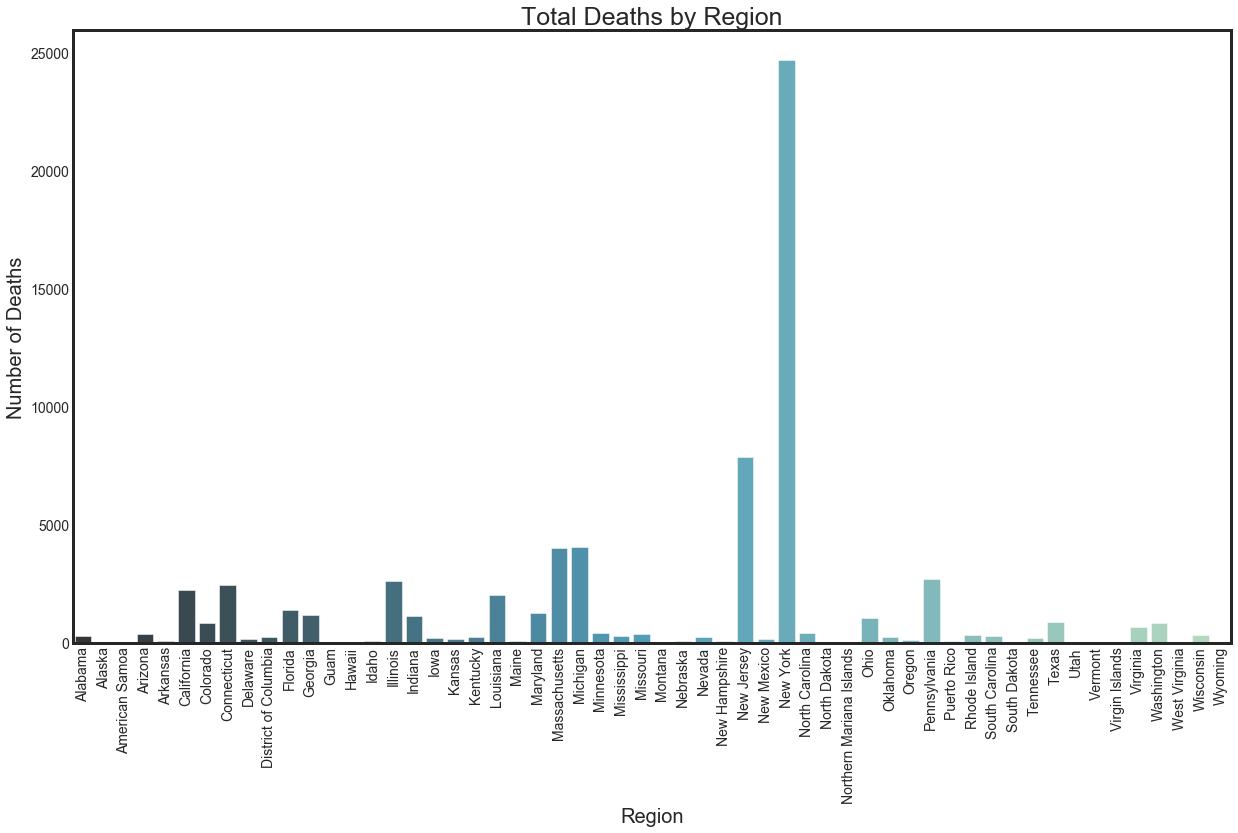

In [583]:
sns.barplot(x="Province_State", y="Norm_Deaths", data=df2, palette="GnBu_d")
plt.title('Deaths per Capita by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Number of Deaths per 100,000 People', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

sns.barplot(x="Province_State", y="Deaths", data=df2, palette="GnBu_d")
plt.title('Total Deaths by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Number of Deaths', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()


The distribution of total deaths and deaths per capita closely follows the distribution of confirmed cases. Once again, New York has far more than the other states.

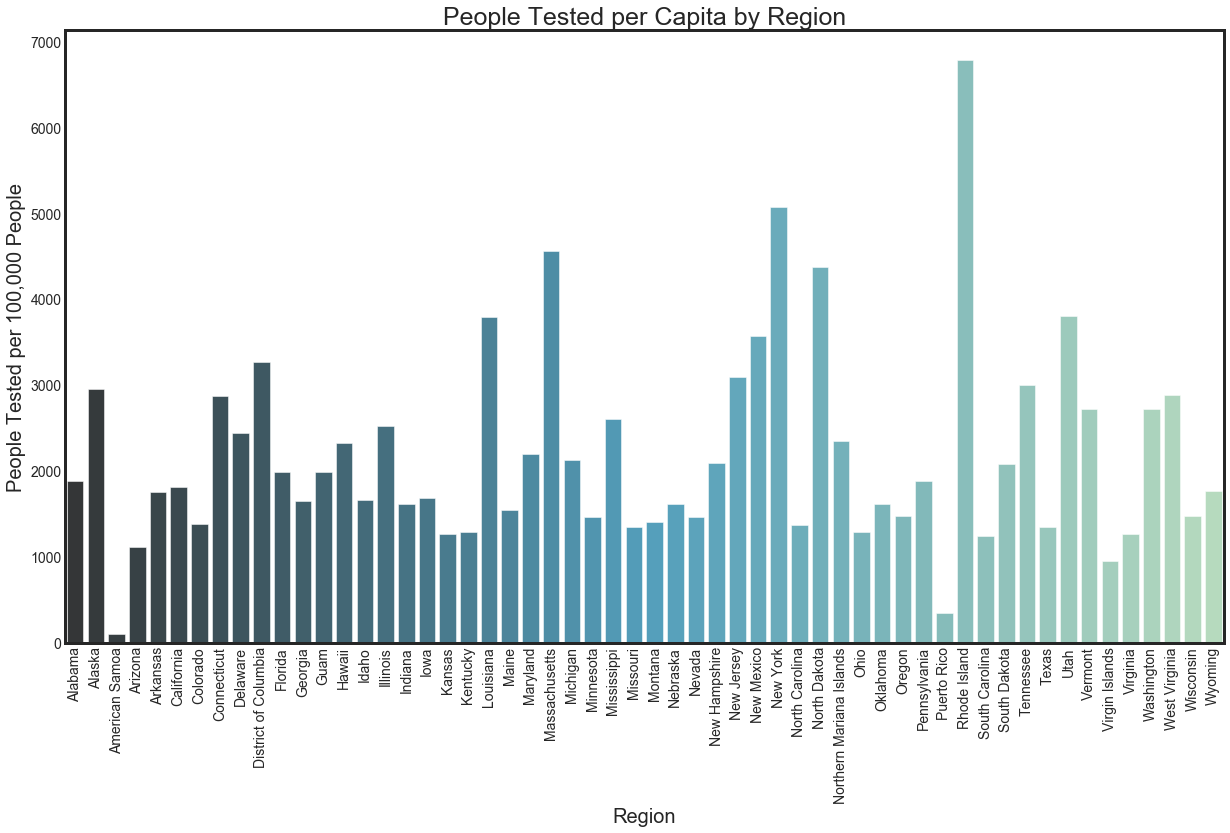

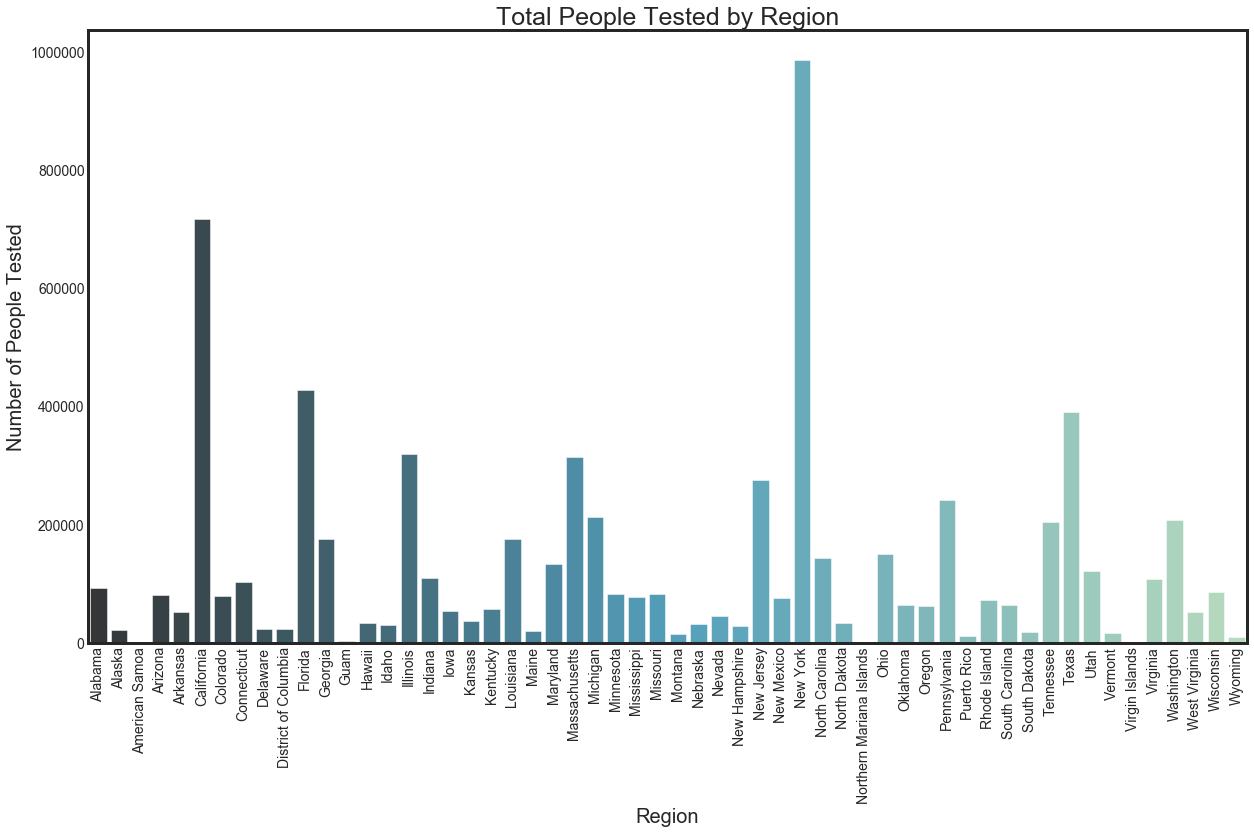

In [584]:
sns.barplot(x="Province_State", y="Norm_Tested", data=df2, palette="GnBu_d")
plt.title('People Tested per Capita by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('People Tested per 100,000 People', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

sns.barplot(x="Province_State", y="People_Tested", data=df2, palette="GnBu_d")
plt.title('Total People Tested by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Number of People Tested', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

Interestingly, the distribution of people tested does not closely follow the distribution of confirmed cases. 
If we look at total tests, New York has the most followed by California. While New York also has the highest total of confirmed
cases and deaths, there are multiple other states that have a greater total of confirmed cases and deaths than California. The 
difference becomes even more glaring if we look at testing per capita, with many states such as Rhode Island that do not have
many confirmed cases per capita surging to the lead.

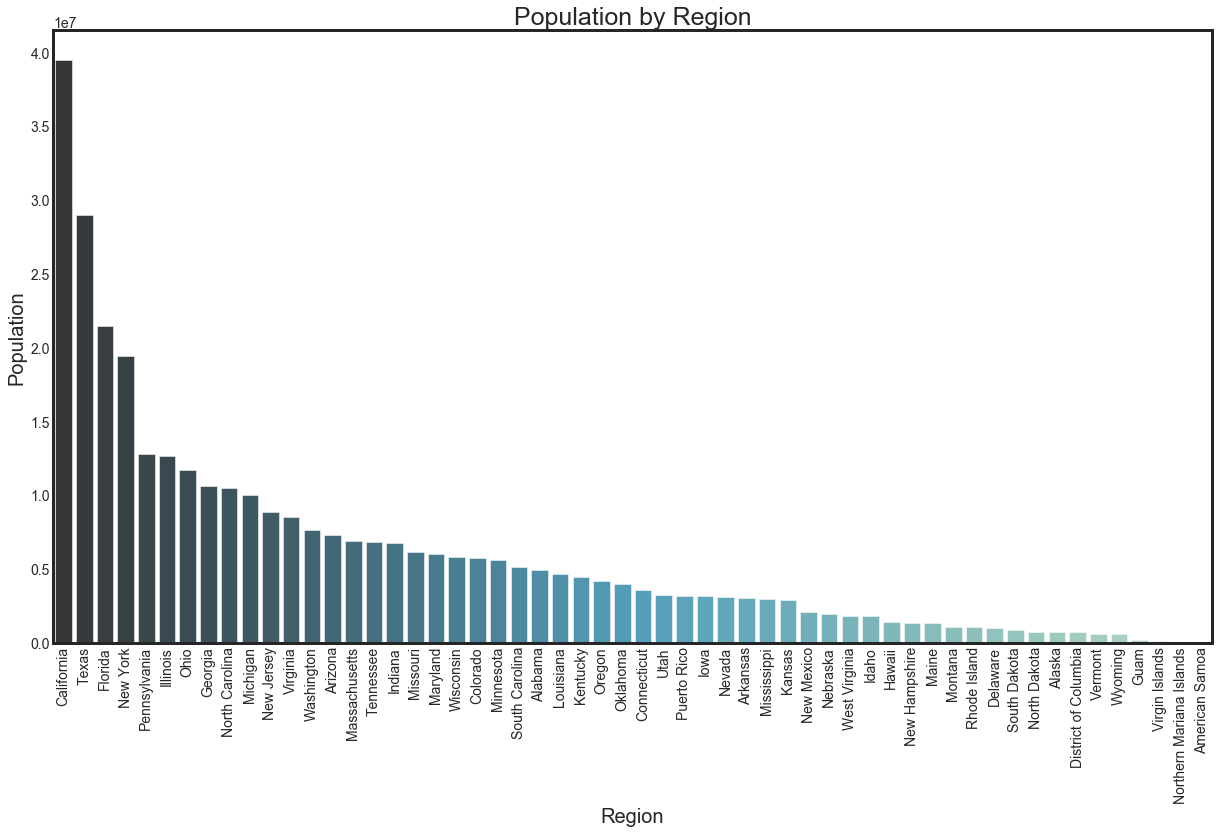

In [617]:
# https://gist.github.com/fomightez/bb5a9c727d93d1508187677b4d74d7c1
result = df2.groupby(["Province_State"])['Population'].aggregate(np.median).reset_index().sort_values('Population', ascending=False)
sns.barplot(x="Province_State", y="Population", data=df2, palette="GnBu_d", order=result['Province_State'])
plt.title('Population by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

The population distribution is very skewed, with states such as California, Texas, Florida and New York having many more people than the other states.

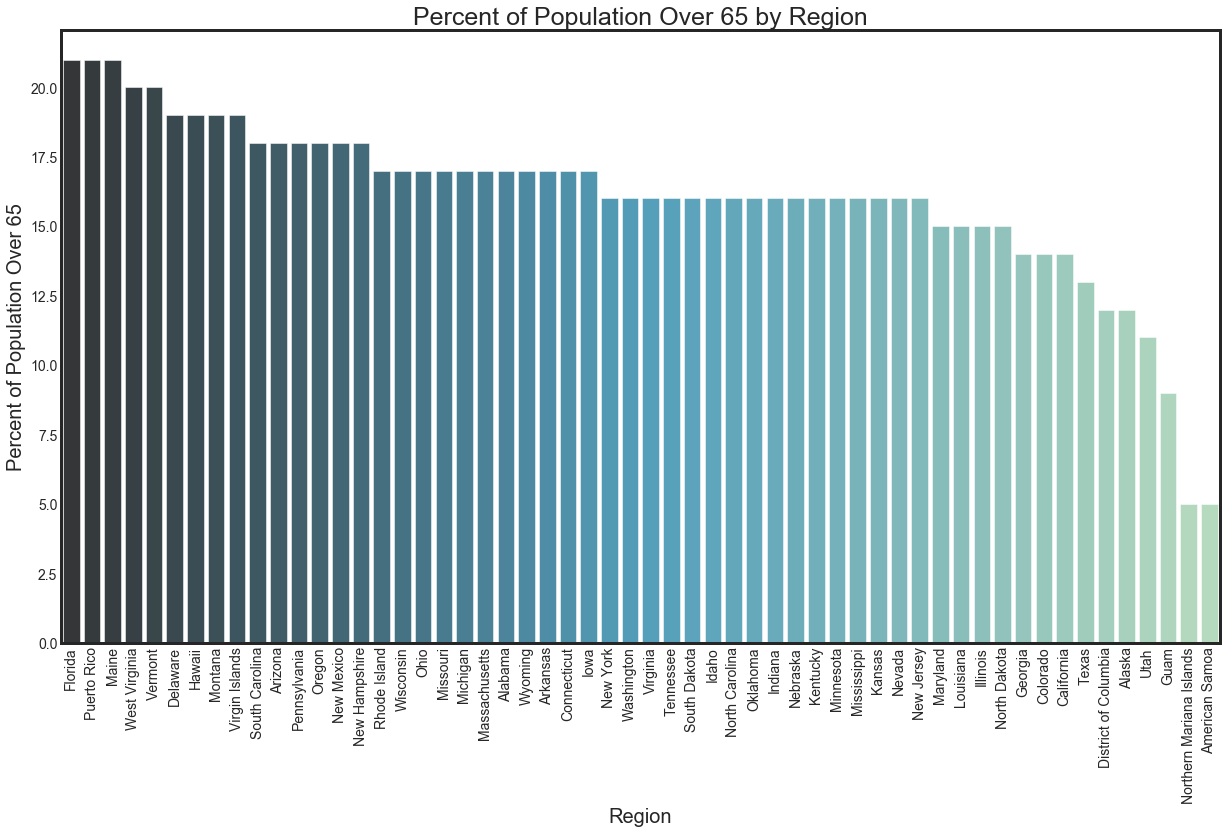

In [618]:
result = df2.groupby(["Province_State"])['Percent_Over_65'].aggregate(np.median).reset_index().sort_values('Percent_Over_65', ascending=False)
sns.barplot(x="Province_State", y="Percent_Over_65", data=df2, palette="GnBu_d", order=result['Province_State'])
plt.title('Percent of Population Over 65 by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Percent of Population Over 65', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

For the most part the percent of population over 65 is fairly similar between the regions, though Florida, Puerto Rico and Maine have older populations than the other regions. Northern Mariana Islands and American Samoa have noticably younger populations than the other regions.

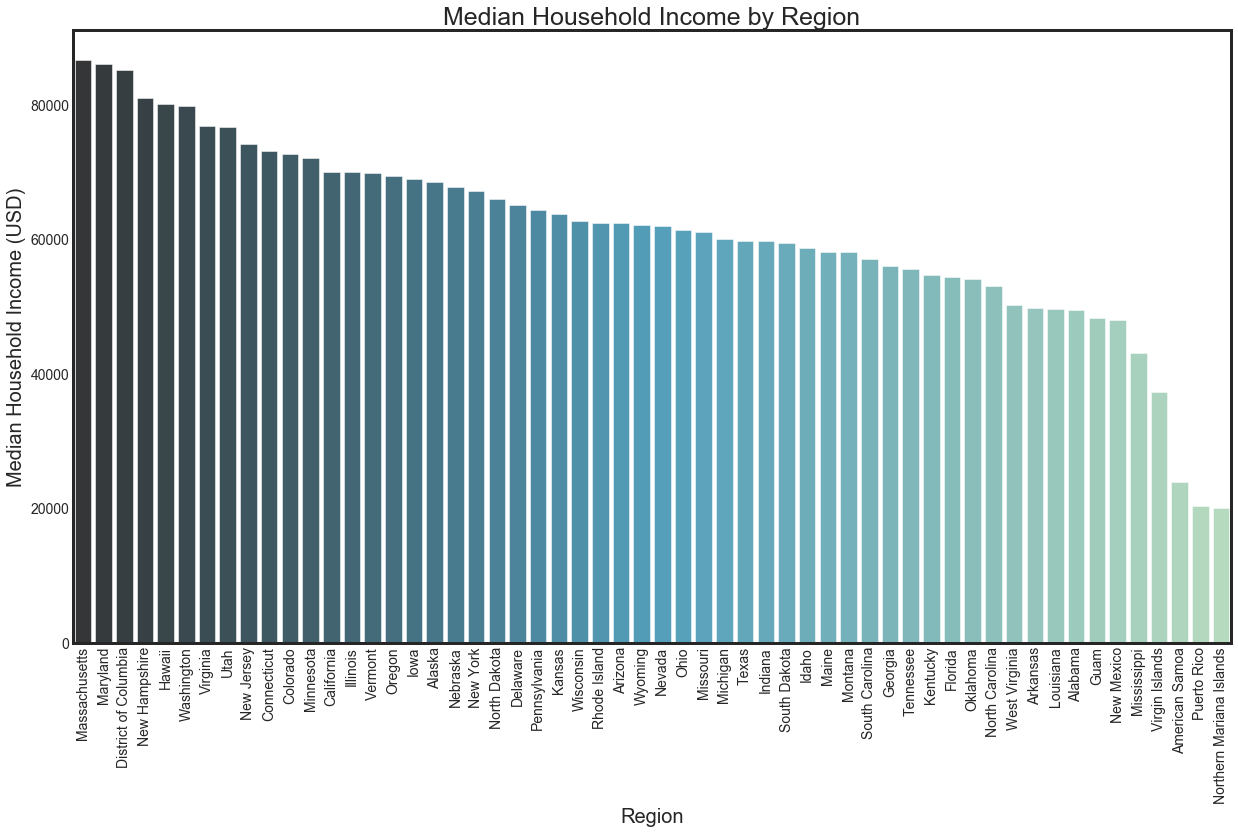

In [619]:
result = df2.groupby(["Province_State"])['Median_Income'].aggregate(np.median).reset_index().sort_values('Median_Income', ascending=False)
sns.barplot(x="Province_State", y="Median_Income", data=df2, palette="GnBu_d", order=result['Province_State'])
plt.title('Median Household Income by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Median Household Income (USD)', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

The territories seem to have lower median household income in general than the states.

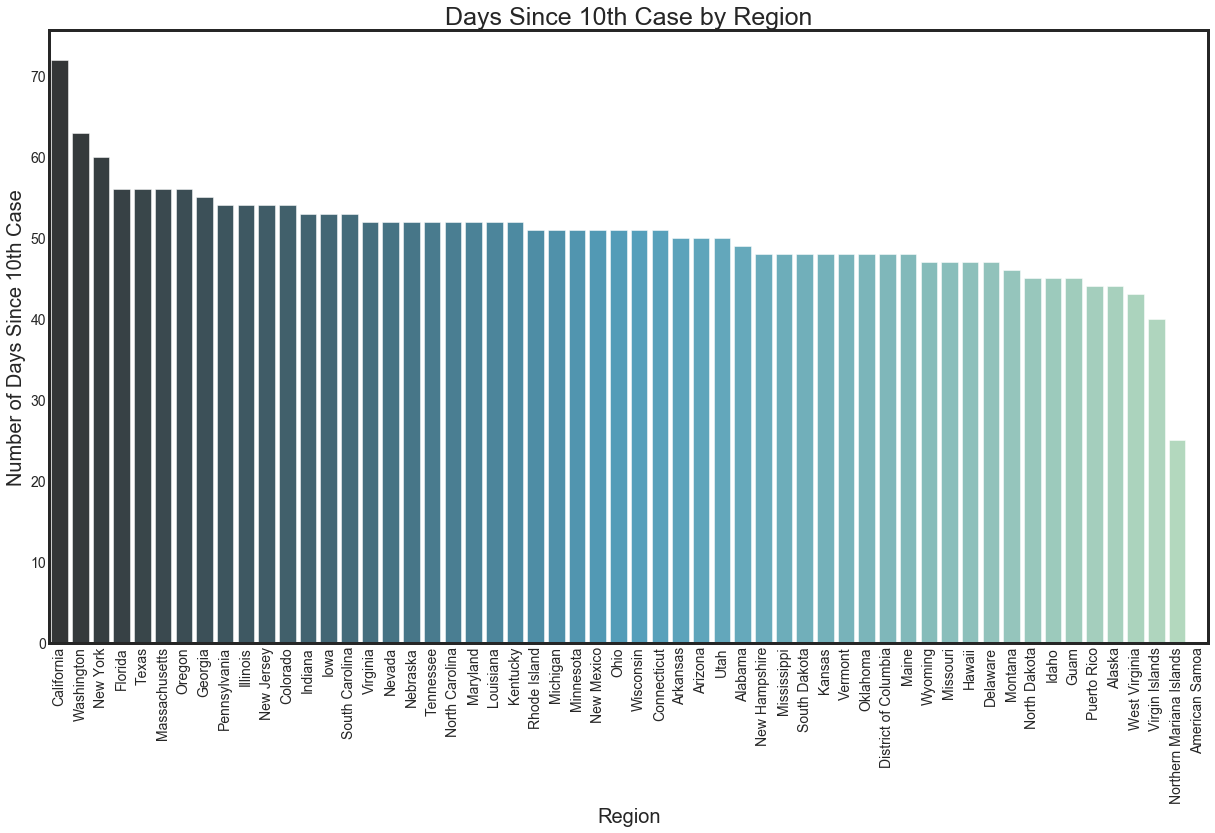

In [620]:
result = df2.groupby(["Province_State"])['Days_since_10th_case'].aggregate(np.median).reset_index().sort_values('Days_since_10th_case', ascending=False)
sns.barplot(x="Province_State", y="Days_since_10th_case", data=df2, palette="GnBu_d", order=result['Province_State'])
plt.title('Days Since 10th Case by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Number of Days Since 10th Case', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

California has had COVID-19 for the longest, while American Samoa has luckily not had any cases to this point.

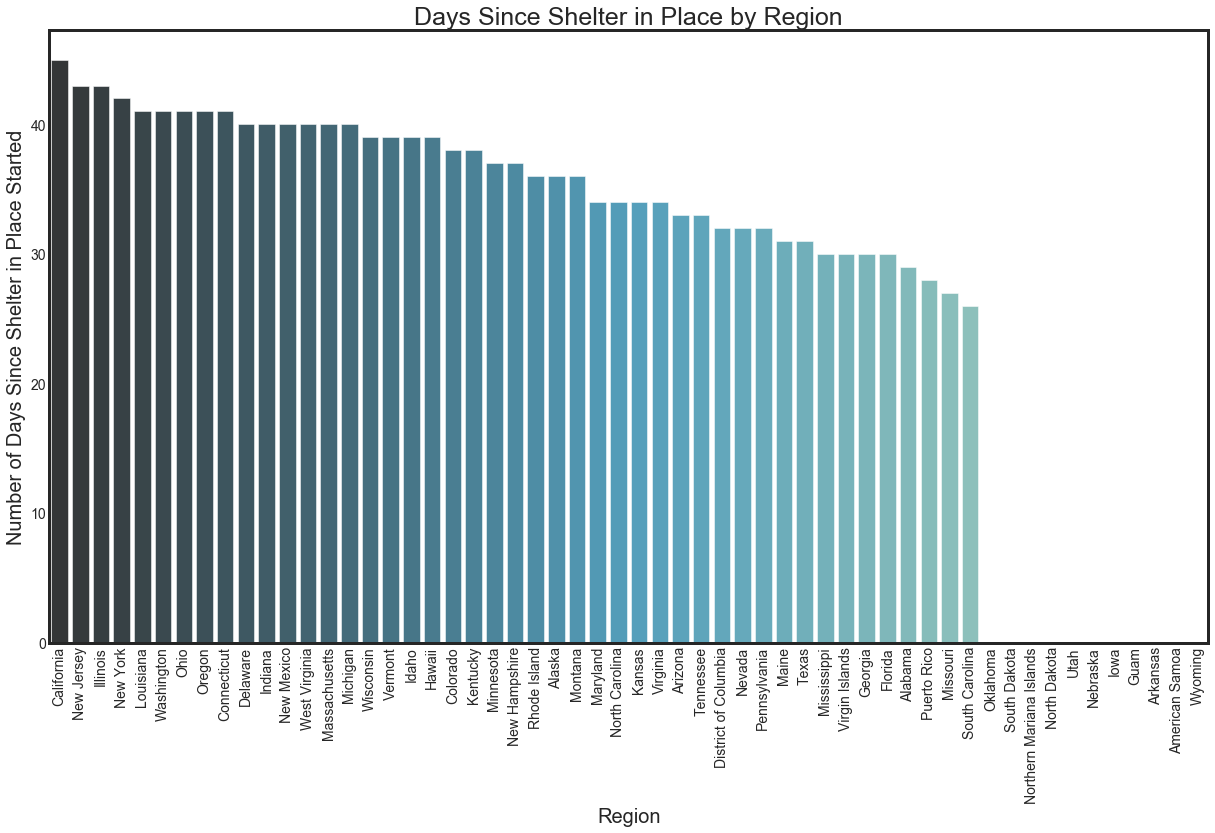

In [621]:
result = df2.groupby(["Province_State"])['Days_Since_Shelter_in_Place'].aggregate(np.median).reset_index().sort_values('Days_Since_Shelter_in_Place', ascending=False)
sns.barplot(x="Province_State", y="Days_Since_Shelter_in_Place", data=df2, palette="GnBu_d", order=result['Province_State'])
plt.title('Days Since Shelter in Place by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Number of Days Since Shelter in Place Started', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Just as California has experienced COVID-19 for the longest, it has also had shelter in place for the longest. Some regions have chosen not to implement shelter in place, though they often have other restrictions such as closing resteraunts and bars.

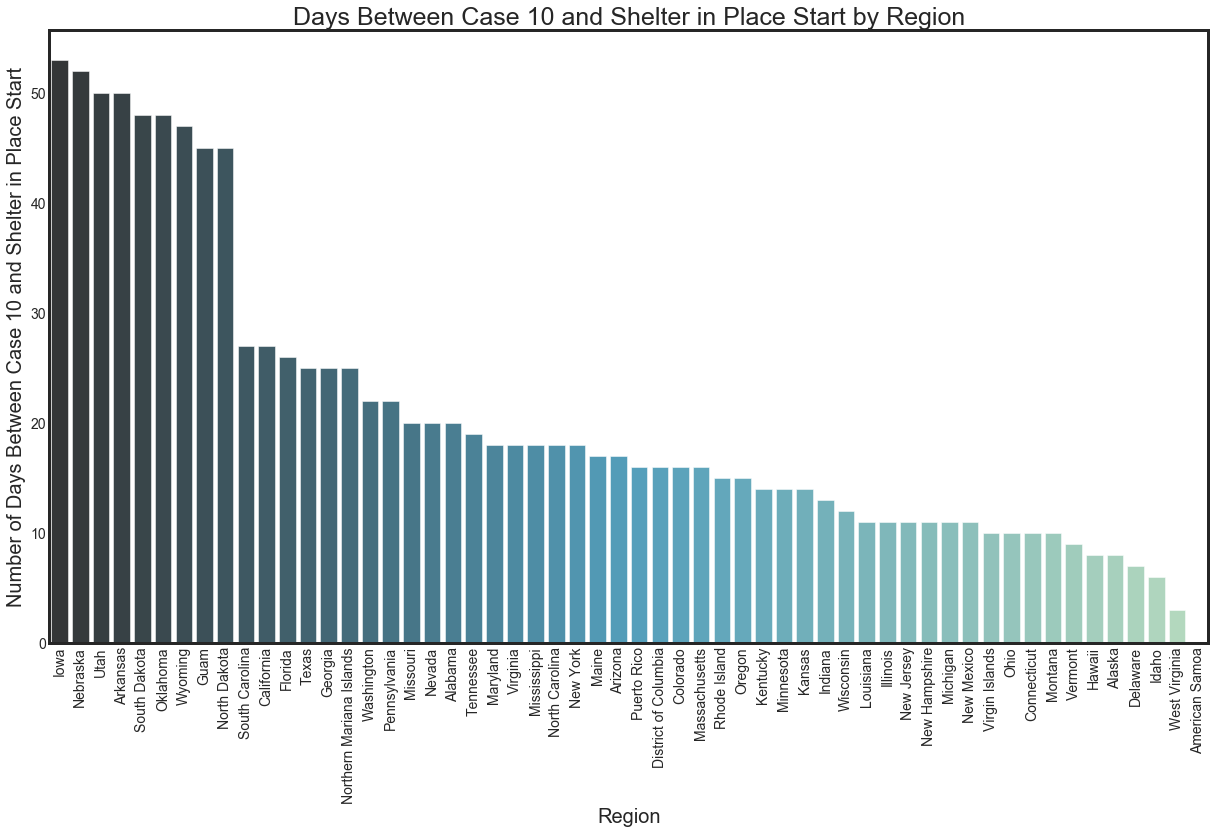

In [614]:
# https://gist.github.com/fomightez/bb5a9c727d93d1508187677b4d74d7c1
result = df2.groupby(["Province_State"])['Days_Between_Case10_SIP'].aggregate(np.median).reset_index().sort_values('Days_Between_Case10_SIP', ascending=False)
sns.barplot(x="Province_State", y="Days_Between_Case10_SIP", data=df2, palette="GnBu_d", order=result['Province_State'])
plt.title('Days Between Case 10 and Shelter in Place Start by Region', fontsize=25)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Number of Days Between Case 10 and Shelter in Place Start', fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Many of the states who appear to have waited the longest to initiate shelter in place on this graph have not put shelter in place into practice. American Samoa is an exception, as though they have not initiated shelter in place they also have not experienced any confirmed cases of COVID-19.

### Relationship Visualizations

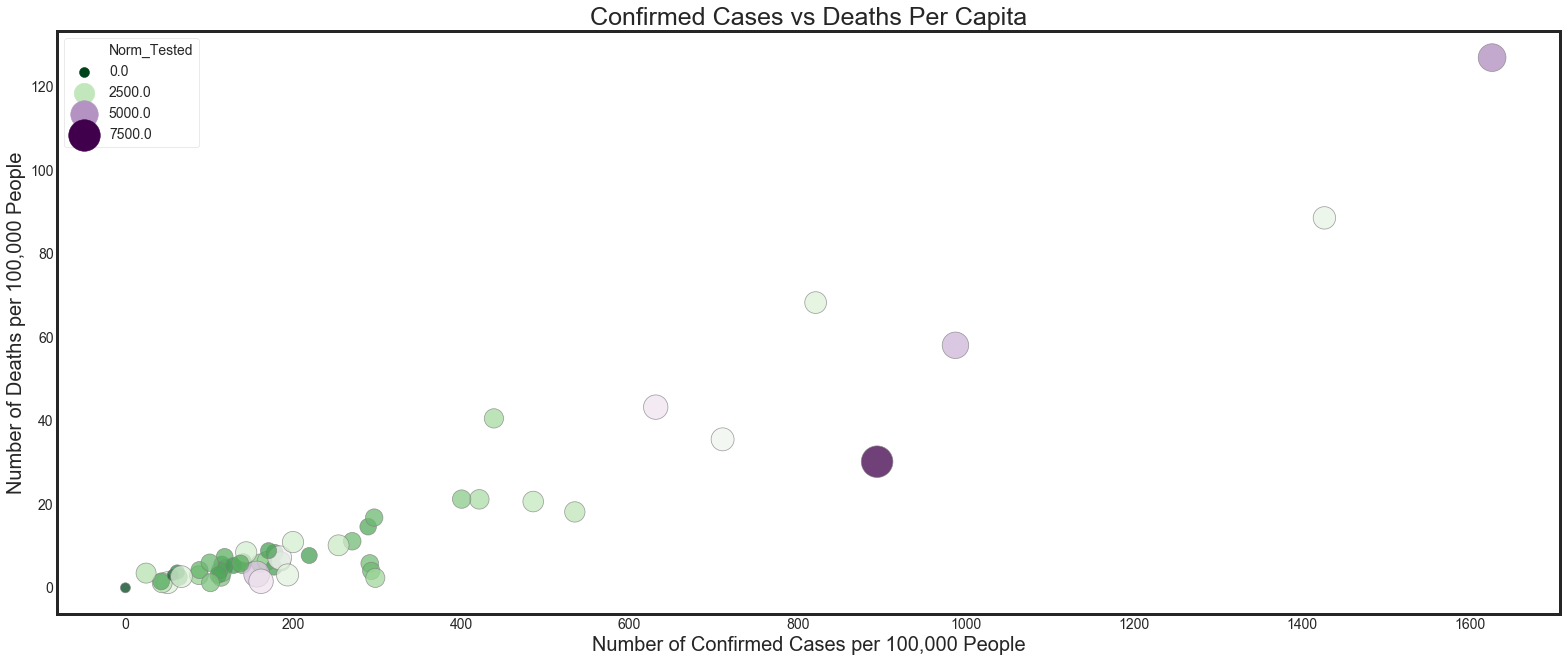

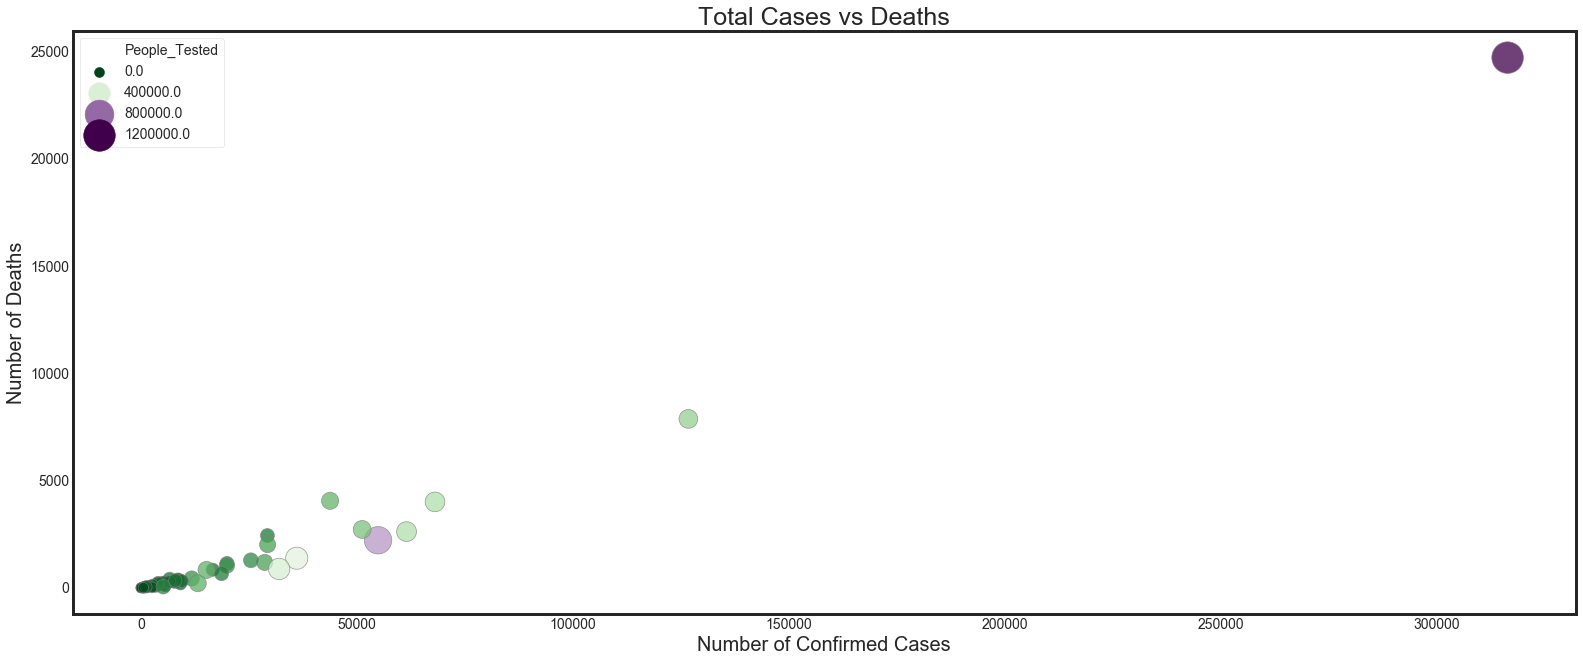

In [675]:
# normed confirmed vs normed deaths
sns.scatterplot(x="Norm_Confirmed", y="Norm_Deaths", data=df2, size="Norm_Tested", hue="Norm_Tested", 
                sizes=(100, 1000), alpha=.75, palette="PRGn_r", edgecolor="grey")
# sns.scatterplot(x="Norm_Confirmed", y="Norm_Deaths", data=df2, size="Days_since_10th_case", hue="Days_since_10th_case", 
#                 sizes=(100, 1000), alpha=.75, palette="PRGn_r")
plt.title('Confirmed Cases vs Deaths Per Capita', fontsize=25)
plt.xlabel('Number of Confirmed Cases per 100,000 People', fontsize=20)
plt.ylabel('Number of Deaths per 100,000 People', fontsize=20)
plt.show()


# confirmed vs deaths
sns.scatterplot(x="Confirmed", y="Deaths", data=df2, size="People_Tested", hue="People_Tested", 
                sizes=(100, 1000), alpha=.75, palette="PRGn_r", edgecolor="grey")
# sns.scatterplot(x="Norm_Confirmed", y="Norm_Deaths", data=df2, size="Days_since_10th_case", hue="Days_since_10th_case", 
#                 sizes=(100, 1000), alpha=.75, palette="PRGn_r")
plt.title('Total Cases vs Deaths', fontsize=25)
plt.xlabel('Number of Confirmed Cases', fontsize=20)
plt.ylabel('Number of Deaths', fontsize=20)
plt.show()

As number of confirmed cases increases, so does number of deaths. 

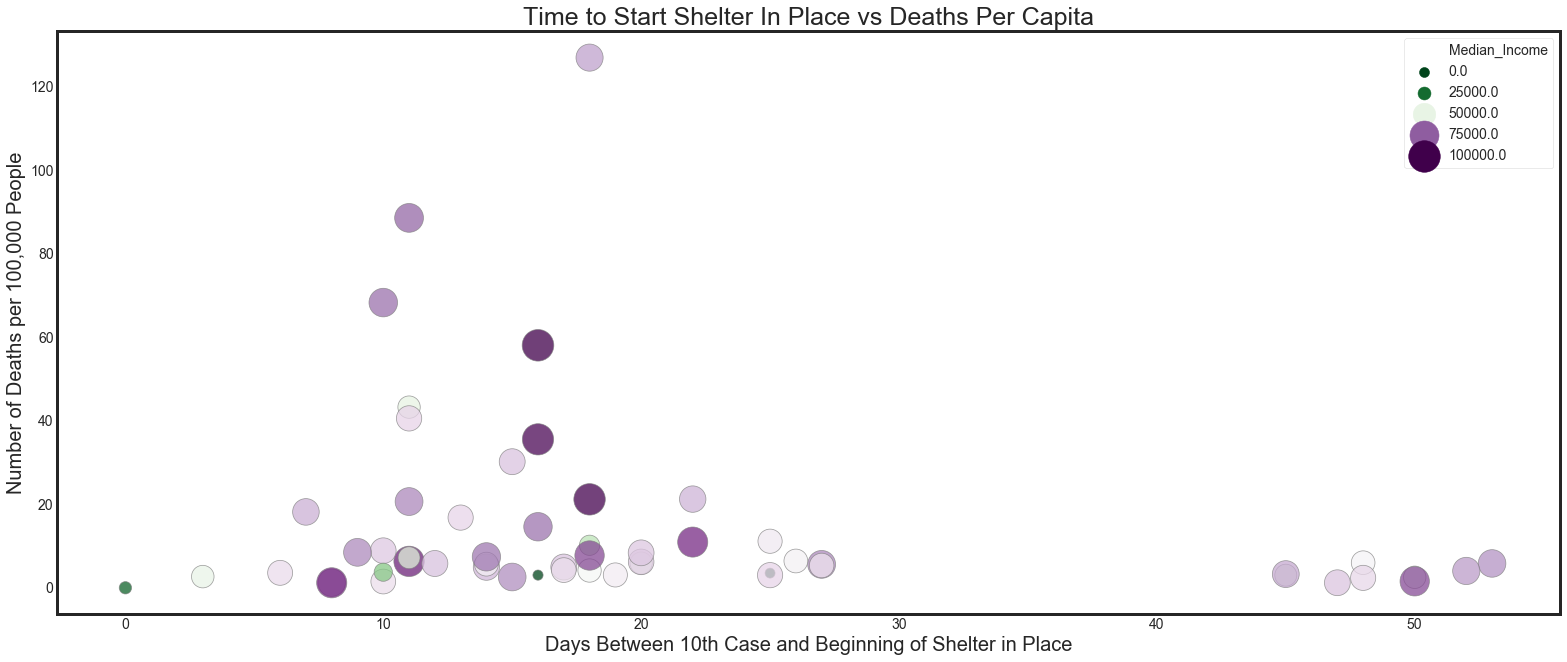

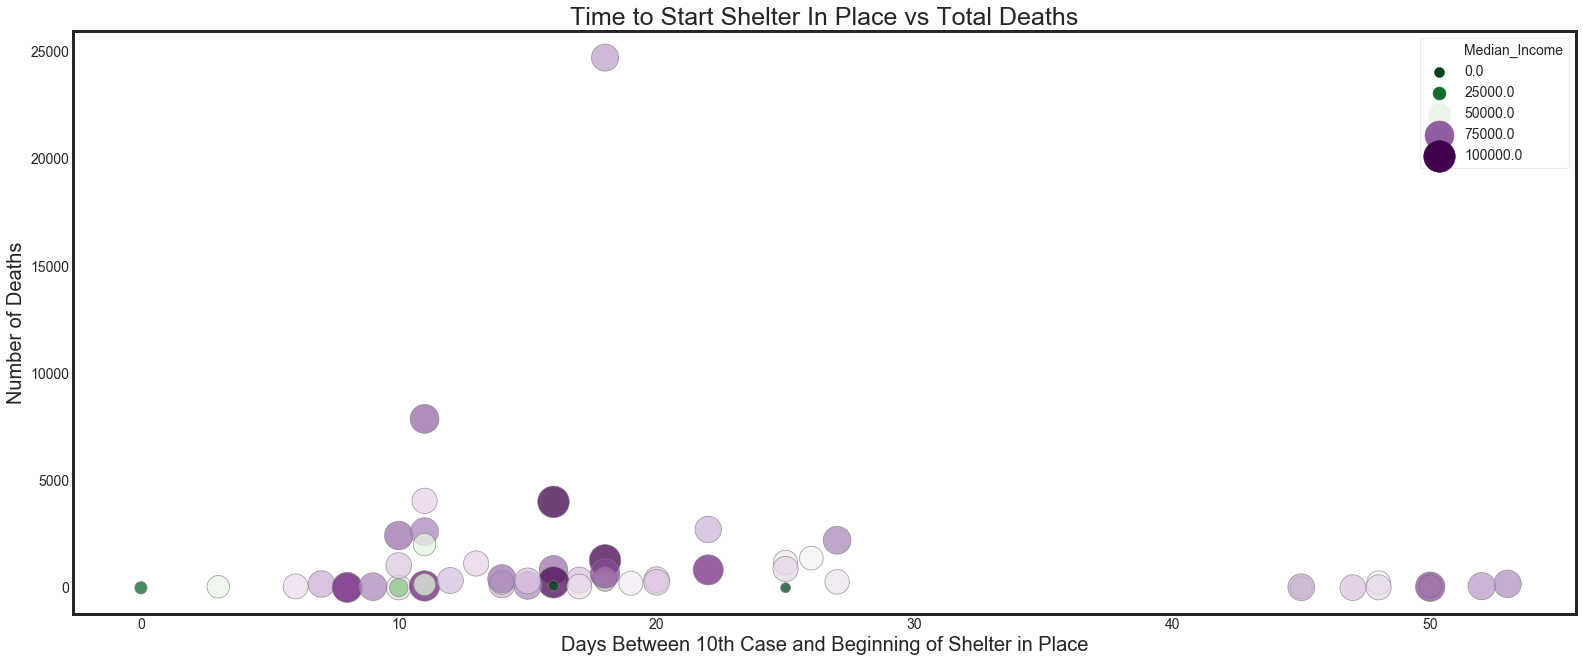

In [678]:
# normed confirmed vs normed deaths
sns.scatterplot(x="Days_Between_Case10_SIP", y="Norm_Deaths", data=df2, size="Median_Income", hue="Median_Income", 
                sizes=(100, 1000), alpha=.75, palette="PRGn_r", edgecolor="grey")
plt.title('Time to Start Shelter In Place vs Deaths Per Capita', fontsize=25)
plt.xlabel('Days Between 10th Case and Beginning of Shelter in Place', fontsize=20)
plt.ylabel('Number of Deaths per 100,000 People', fontsize=20)
plt.show()

# normed confirmed vs normed deaths
sns.scatterplot(x="Days_Between_Case10_SIP", y="Deaths", data=df2, size="Median_Income", hue="Median_Income", 
                sizes=(100, 1000), alpha=.75, palette="PRGn_r", edgecolor="grey")
plt.title('Time to Start Shelter In Place vs Total Deaths', fontsize=25)
plt.xlabel('Days Between 10th Case and Beginning of Shelter in Place', fontsize=20)
plt.ylabel('Number of Deaths', fontsize=20)
plt.show()

There does not seem to be a clear relationship between time to start shelter in place and number of deaths.

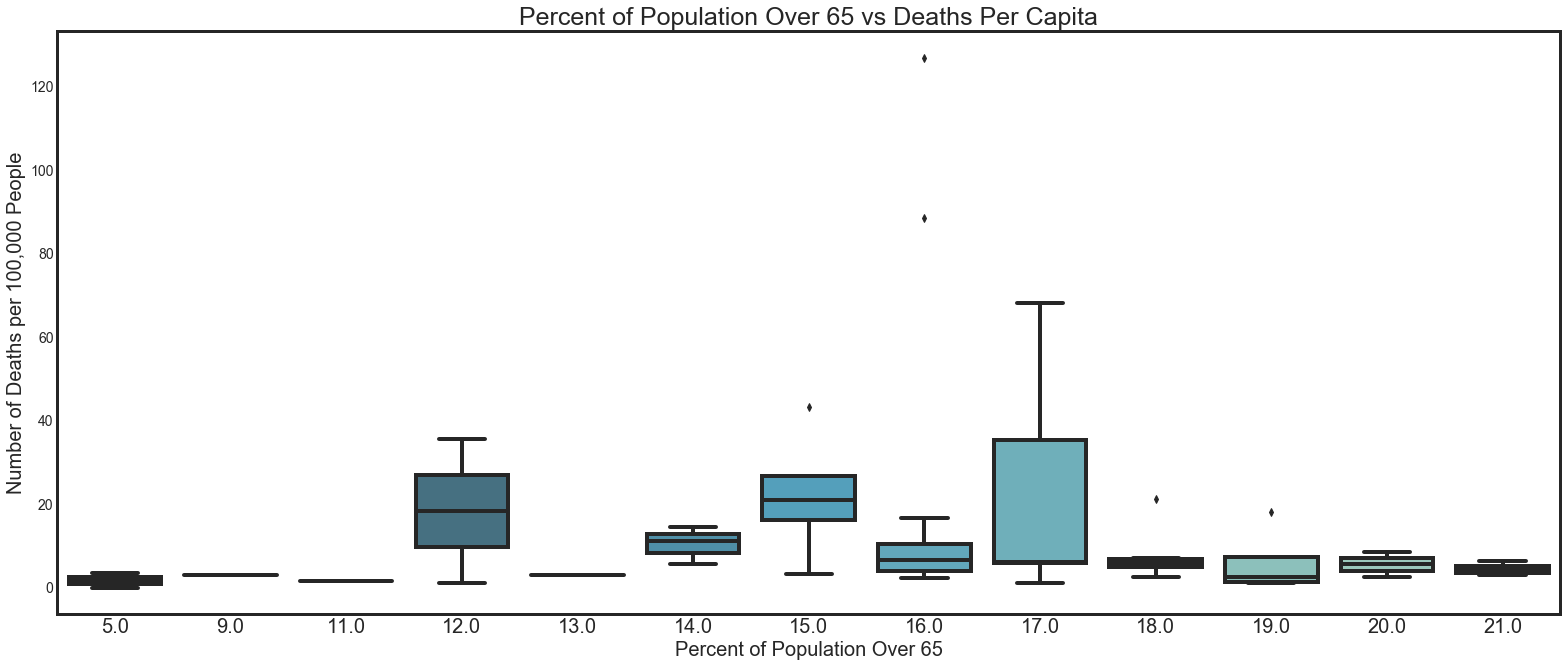

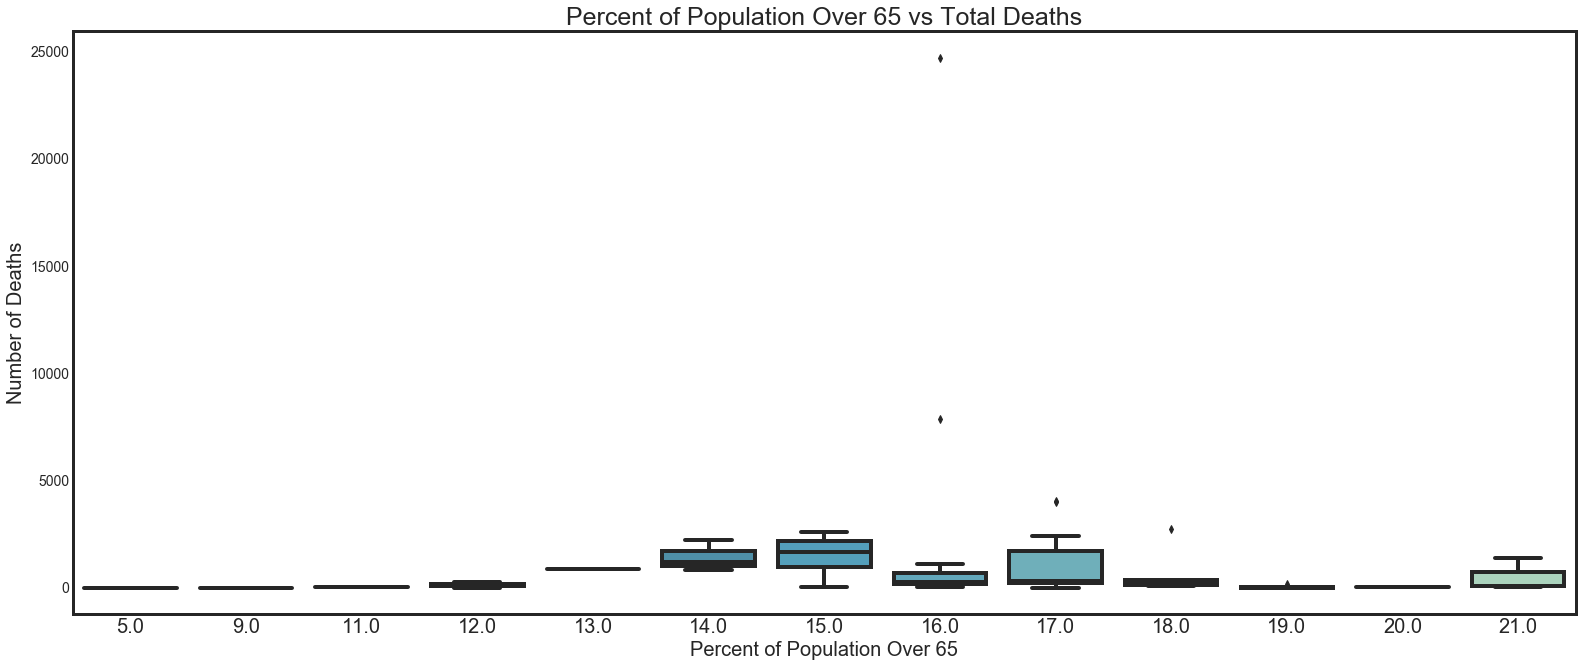

In [686]:
sns.boxplot(x="Percent_Over_65", y="Norm_Deaths", data=df2, palette="GnBu_d")
plt.title('Percent of Population Over 65 vs Deaths Per Capita', fontsize=25)
plt.xlabel('Percent of Population Over 65', fontsize=20)
plt.ylabel('Number of Deaths per 100,000 People', fontsize=20)
plt.xticks(fontsize=20)
plt.show()

sns.boxplot(x="Percent_Over_65", y="Deaths", data=df2, palette="GnBu_d")
plt.title('Percent of Population Over 65 vs Total Deaths', fontsize=25)
plt.xlabel('Percent of Population Over 65', fontsize=20)
plt.ylabel('Number of Deaths', fontsize=20)
plt.xticks(fontsize=20)
plt.show()

Regions with a higher percentage of people over 65 do not necessarily have more deaths.

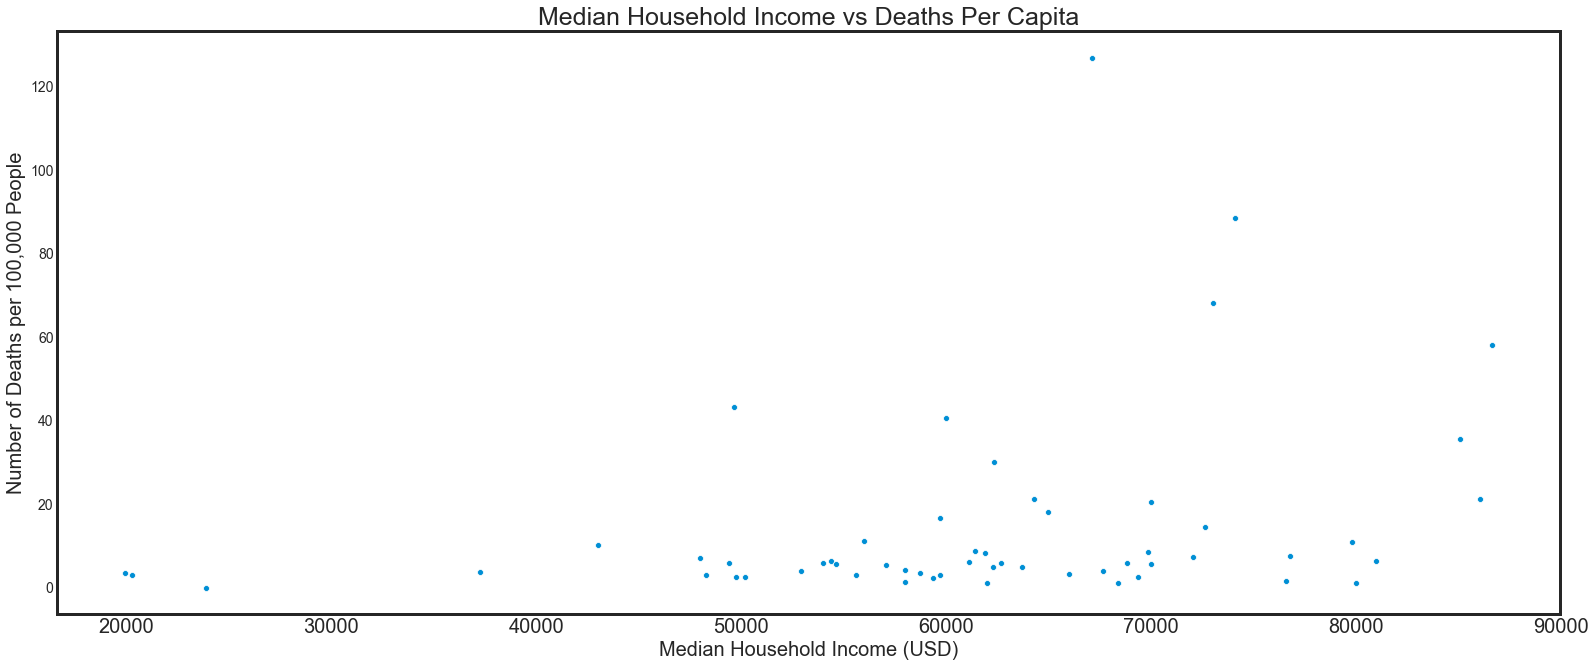

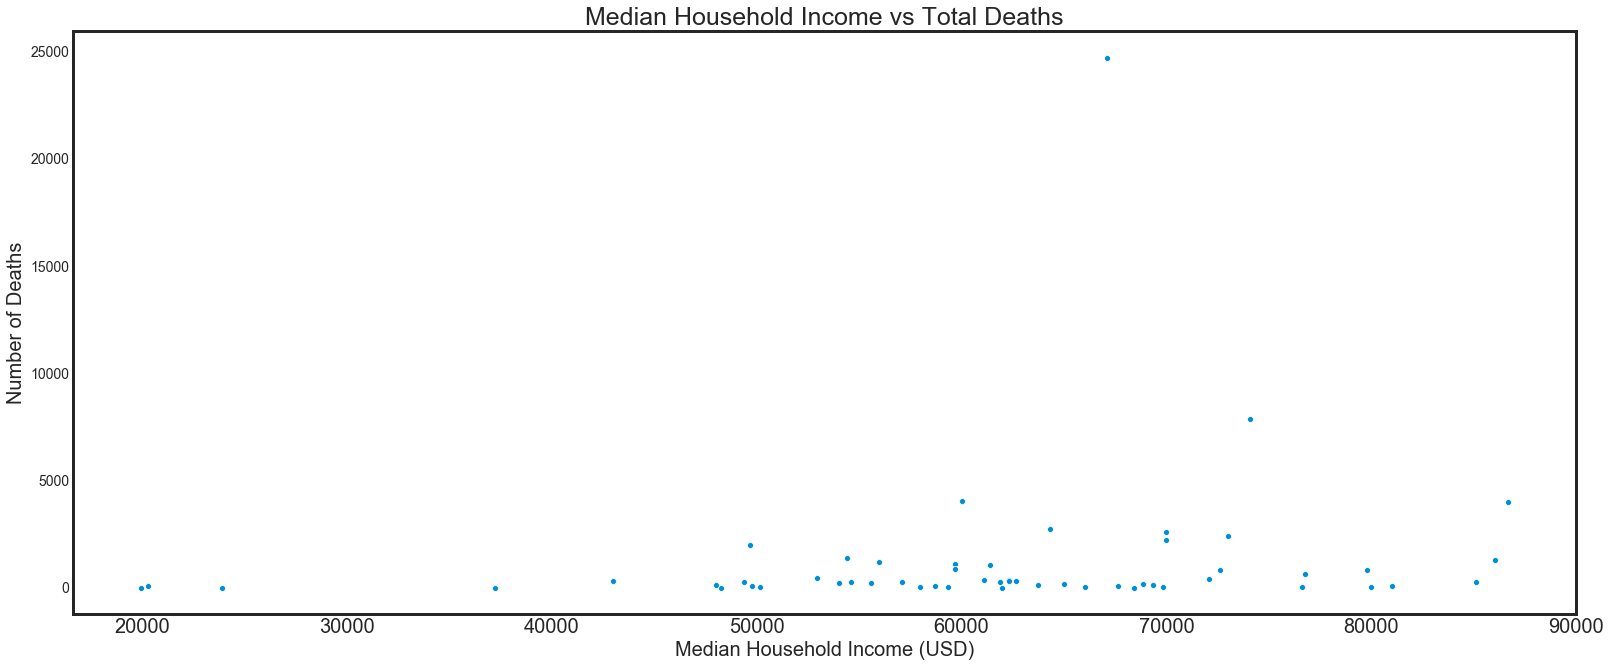

In [687]:
sns.scatterplot(x="Median_Income", y="Norm_Deaths", data=df2)
plt.title('Median Household Income vs Deaths Per Capita', fontsize=25)
plt.xlabel('Median Household Income (USD)', fontsize=20)
plt.ylabel('Number of Deaths per 100,000 People', fontsize=20)
plt.xticks(fontsize=20)
plt.show()

sns.scatterplot(x="Median_Income", y="Deaths", data=df2)
plt.title('Median Household Income vs Total Deaths', fontsize=25)
plt.xlabel('Median Household Income (USD)', fontsize=20)
plt.ylabel('Number of Deaths', fontsize=20)
plt.xticks(fontsize=20)
plt.show()

Median household income also does not seem directly related to deaths per capita.

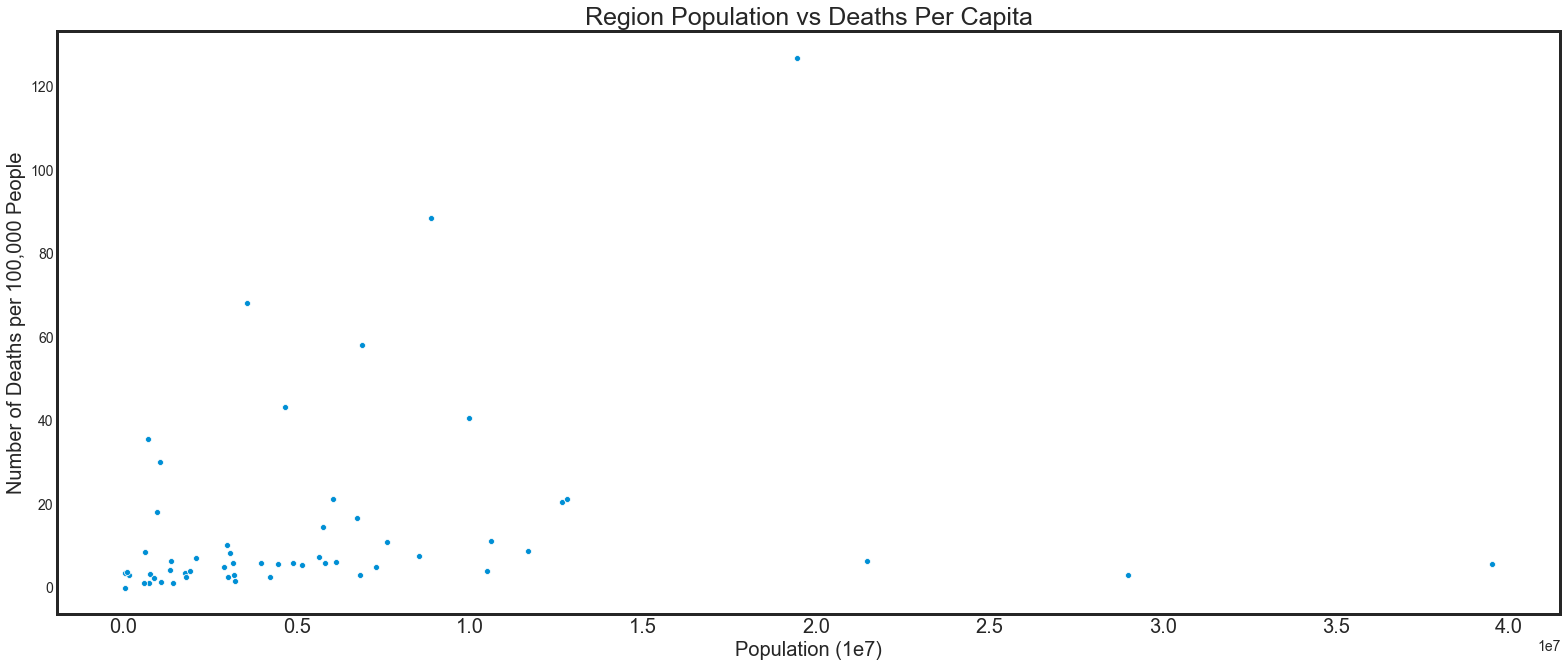

In [697]:
sns.scatterplot(x="Population", y="Norm_Deaths", data=df2)
plt.title('Region Population vs Deaths Per Capita', fontsize=25)
plt.xlabel('Population (1e7)', fontsize=20)
plt.ylabel('Number of Deaths per 100,000 People', fontsize=20)
plt.xticks(fontsize=20)
plt.show()

Regions with higher populations seem to have more deaths per capita, possibly due to having more population concentrated in cities making it easier for the virus to spread.

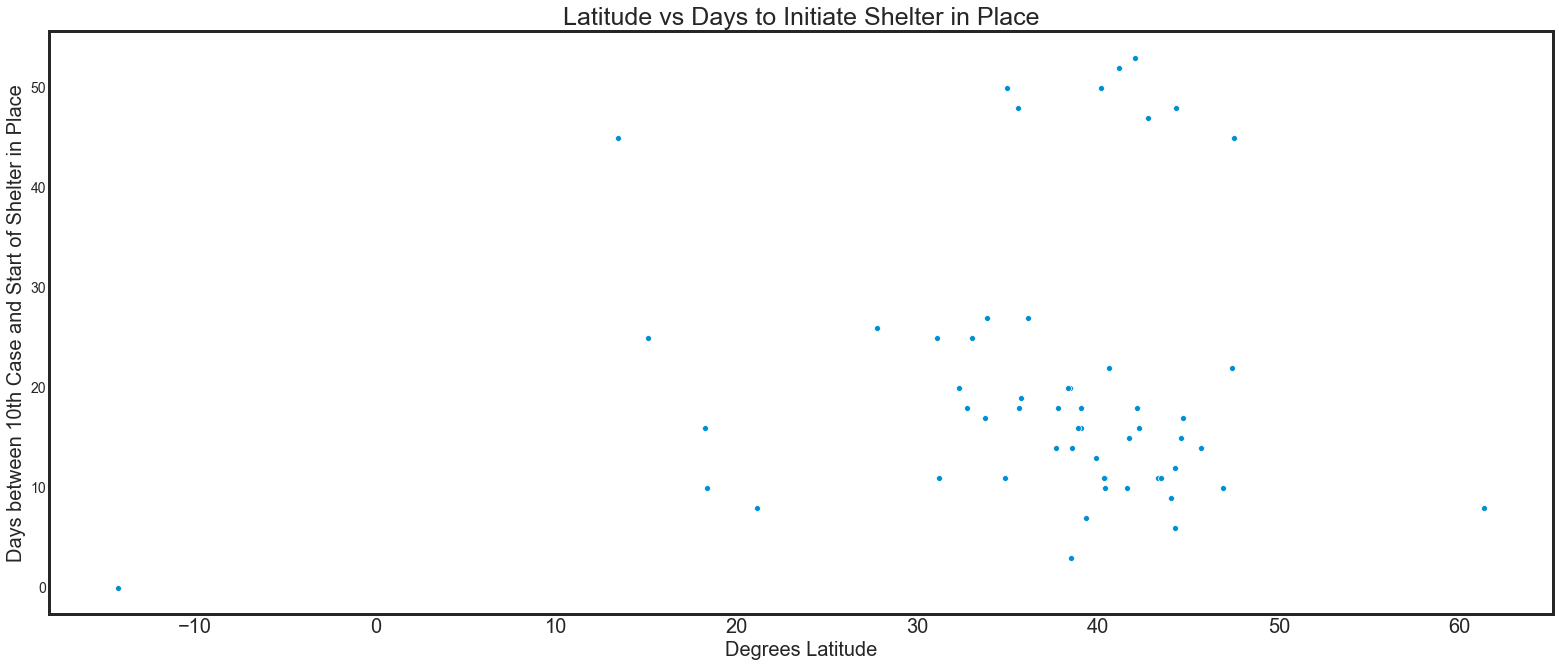

In [699]:
sns.scatterplot(x="Lat", y="Days_Between_Case10_SIP", data=df2)
plt.title('Latitude vs Days to Initiate Shelter in Place', fontsize=25)
plt.xlabel('Degrees Latitude', fontsize=20)
plt.ylabel('Days between 10th Case and Start of Shelter in Place', fontsize=20)
plt.xticks(fontsize=20)
plt.show()


There does not seem to be a clear relationship between latitude and time to initiate shelter in place.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]), <a list of 56 Text xticklabel objects>)

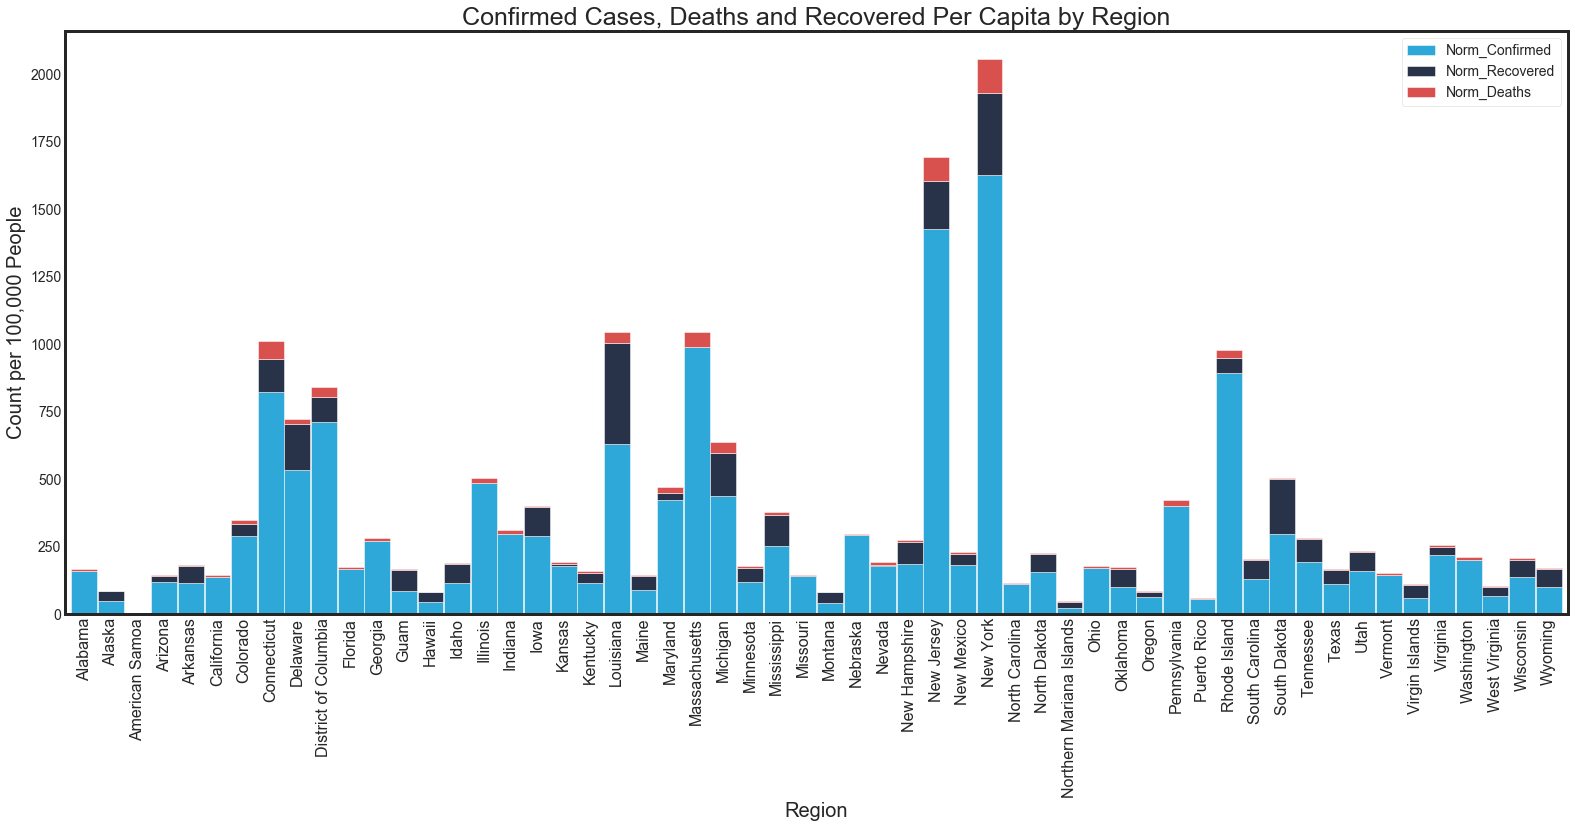

In [560]:
#df2.Norm_Confirmed + df2.Norm_Deaths + df2.Norm_Recovered
df2.set_index('Province_State')[["Norm_Confirmed", "Norm_Recovered", "Norm_Deaths"]].plot(kind="bar", stacked=True, width=0.97,
                                                                                         color=['#2DA8D8FF', '#28334AFF', '#D9514EFF'],
                                                                                         edgecolor='white')
plt.title("Confirmed Cases, Deaths and Recovered Per Capita by Region", fontsize=25)
plt.xlabel("Region", fontsize=20)
plt.ylabel("Count per 100,000 People", fontsize=20)
plt.xticks(rotation=90, fontsize=16)

# color=['#28334AFF', '#FBDE44FF', 'coral']
# '#2DA8D8FF', '#2A2B2DFF', '#D9514EFF'

The number of recovered and deaths do not always seem to be proportional to number of confirmed, for example Massachusetts does not seem to have many recovered. The disparity in recovered could be due to an different data gathering and measuring between regions.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]), <a list of 56 Text xticklabel objects>)

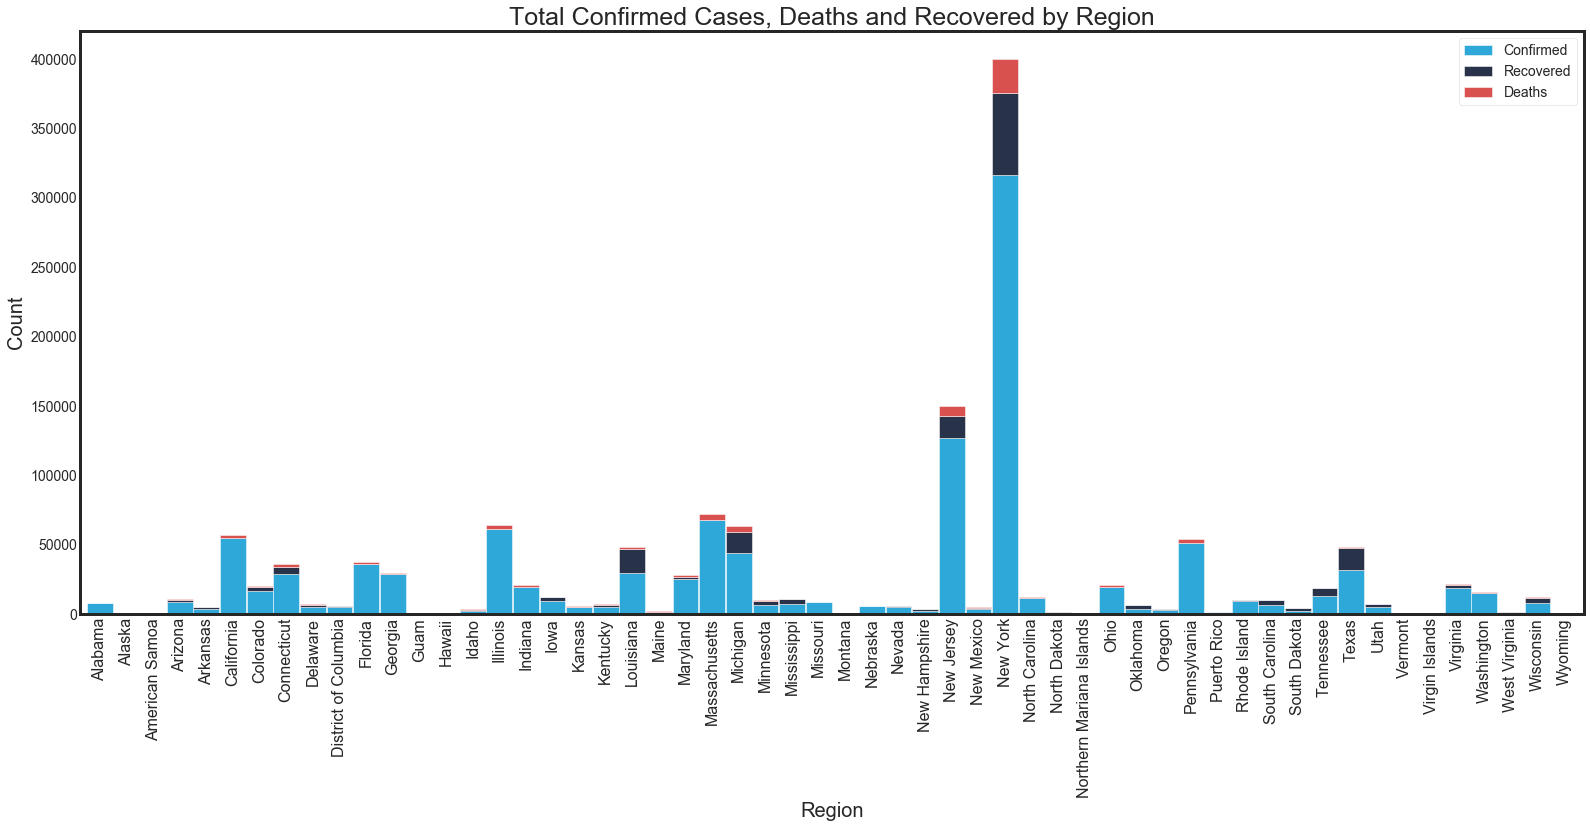

In [559]:
#df2.Confirmed + df2.Deaths + df2.Recovered
df2.set_index('Province_State')[["Confirmed", "Recovered", "Deaths"]].plot(kind="bar", stacked=True, width=0.97,
                                                                                         color=['#2DA8D8FF', '#28334AFF', '#D9514EFF'],
                                                                                         edgecolor='white',)
plt.title("Total Confirmed Cases, Deaths and Recovered by Region", fontsize=25)
plt.xlabel("Region", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(rotation=90, fontsize=16)

# color=['#28334AFF', '#FBDE44FF', 'coral']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]), <a list of 56 Text xticklabel objects>)

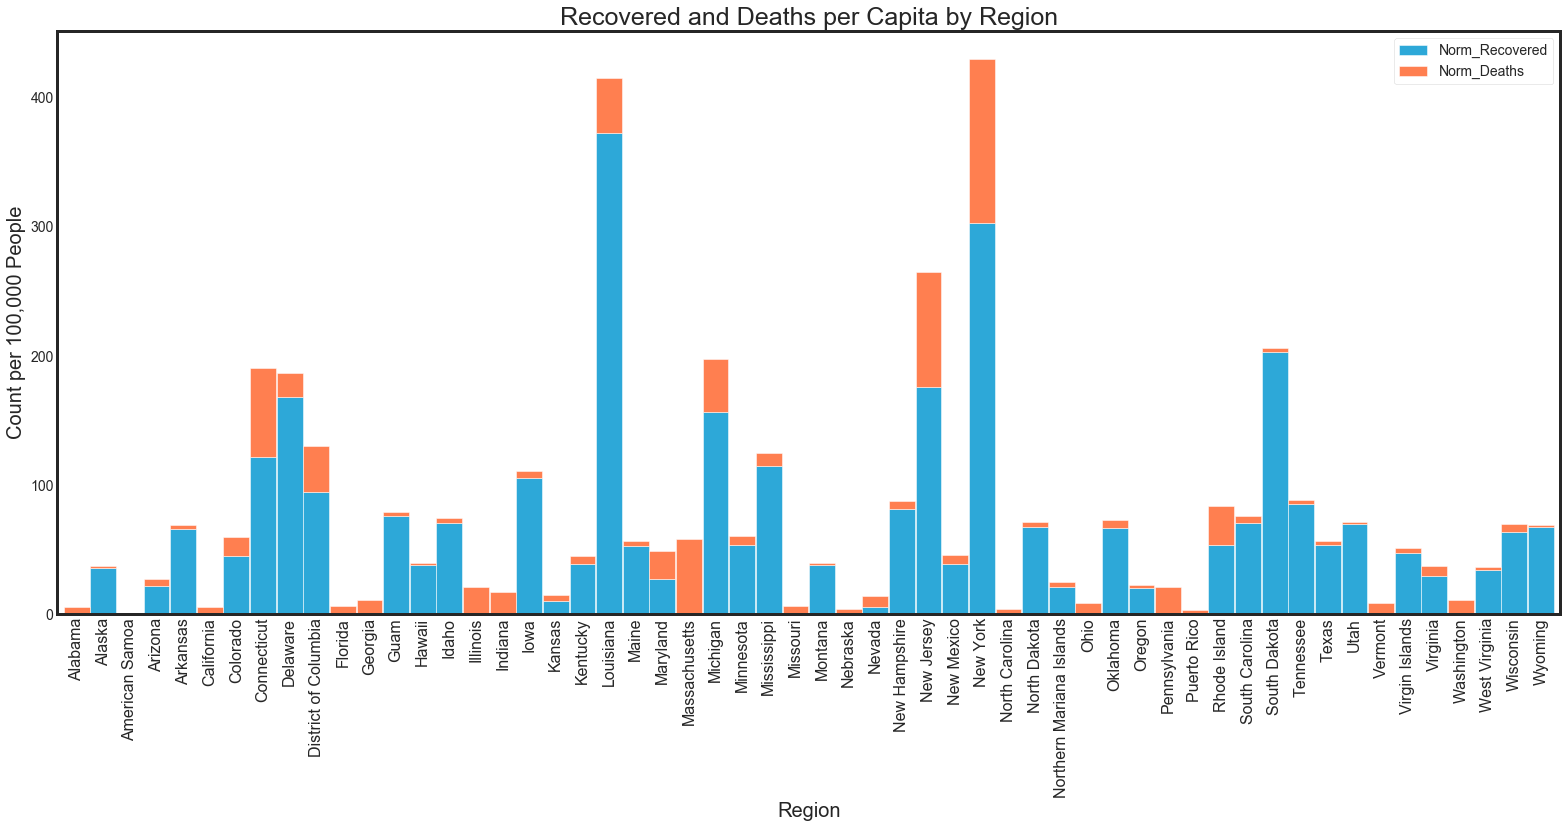

In [566]:
# norm_recovered, normdeaths

df2.set_index('Province_State')[["Norm_Recovered", "Norm_Deaths"]].plot(kind="bar", stacked=True, width=0.97,
                                                                                         color=['#2DA8D8FF', 'coral'],
                                                                                         edgecolor='white',)
plt.title("Recovered and Deaths per Capita by Region", fontsize=25)
plt.xlabel("Region", fontsize=20)
plt.ylabel("Count per 100,000 People", fontsize=20)
plt.xticks(rotation=90, fontsize=16)

# color=['#28334AFF', '#FBDE44FF', 'coral']

Louisiana seems to have a high proportion of people recovered as opposed to dead, while Connecticut shows the opposite pattern. It is hard to know if these trends are due to real occurences or reporting disparity.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]), <a list of 56 Text xticklabel objects>)

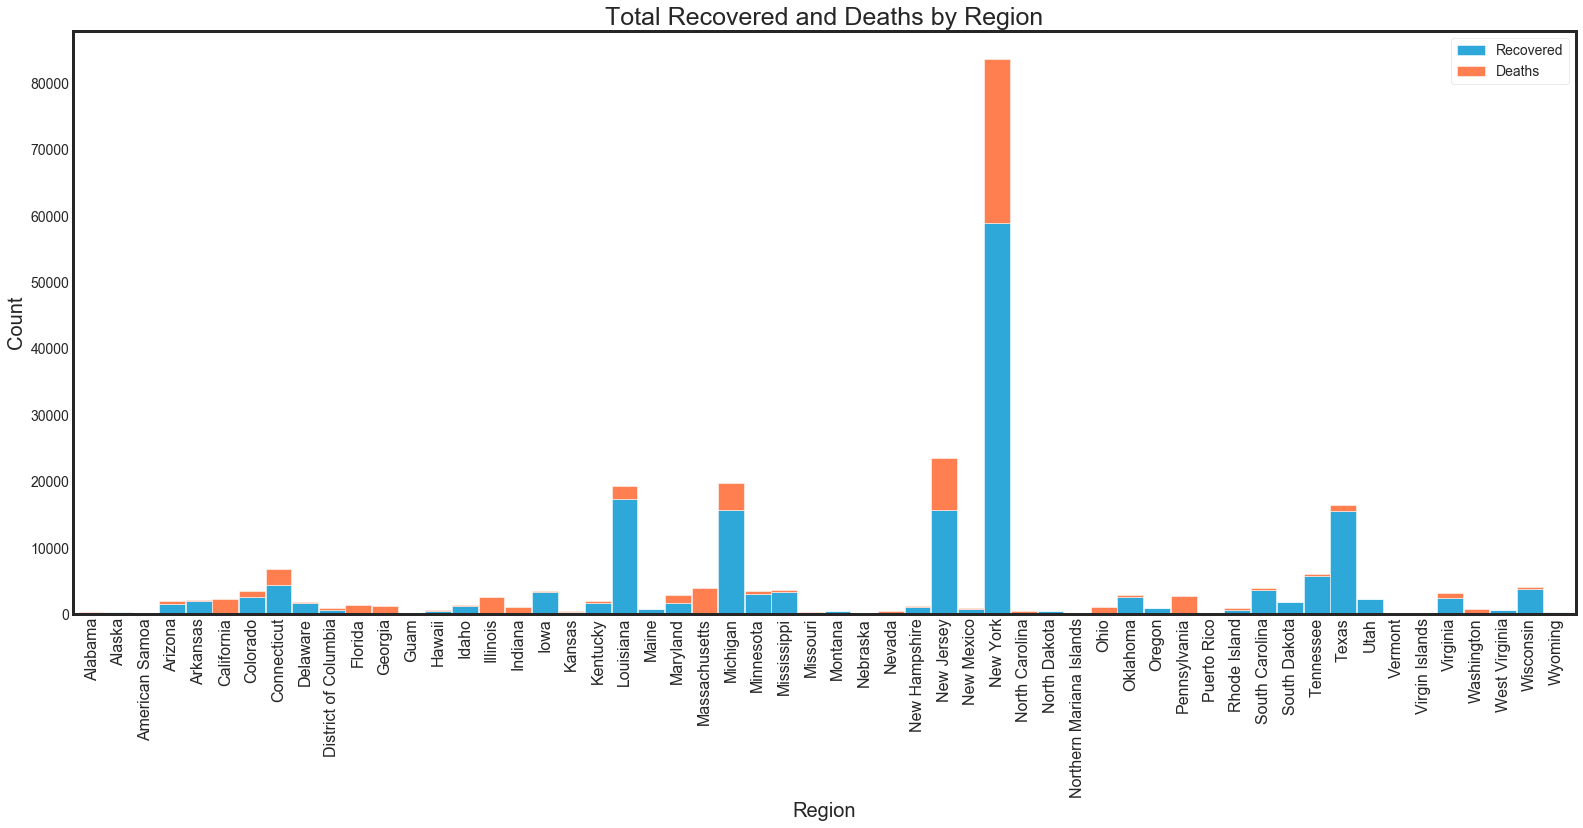

In [567]:
df2.set_index('Province_State')[["Recovered", "Deaths"]].plot(kind="bar", stacked=True, width=0.97,
                                                                                         color=['#2DA8D8FF', 'coral'],
                                                                                         edgecolor='white',)
plt.title("Total Recovered and Deaths by Region", fontsize=25)
plt.xlabel("Region", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(rotation=90, fontsize=16)

### Regression

#### Data Preprocessing

In [9]:
df3 = df2.copy(deep=True)

In [10]:
df3.set_index('Province_State', inplace=True)

In [364]:
df3.head()

Lat     Long_  Confirmed  Deaths  Recovered  Active  \
Province_State                                                            
Alabama         32.3182  -86.9023     7888.0   290.0        0.0  7598.0   
Alaska          61.3707 -152.4044      368.0     9.0      262.0    97.0   
American Samoa -14.2710 -170.1320        0.0     0.0        0.0     0.0   
Arizona         33.7298 -111.4312     8640.0   362.0     1597.0  6681.0   
Arkansas        34.9697  -92.3731     3437.0    76.0     1999.0  1362.0   

                Incident_Rate  People_Tested  Mortality_Rate  Testing_Rate  \
Province_State                                                               
Alabama            168.227197        92500.0        3.676471   1972.745403   
Alaska              61.564302        21578.0        2.445652   3609.876386   
American Samoa       0.000000           57.0             NaN    102.442444   
Arizona            118.702238        81119.0        4.189815   1114.468388   
Arkansas           132.752575        52890.0        2.211231   2042.852392   

                         ...             Norm_Recovered  Norm_Active  \
Province_State           ...                                           
Alabama                  ...                   0.000000   154.960500   
Alaska                   ...                  35.814612    13.259608   
American Samoa           ...                   0.000000     0.000000   
Arizona                  ...                  21.940680    91.788154   
Arkansas                 ...                  66.240220    45.132156   

                Norm_Tested  Percent_Over_65  Median_Income  \
Province_State                                                
Alabama         1886.528858             17.0        49396.0   
Alaska          2949.647664             12.0        68400.0   
American Samoa   102.767511              5.0        23892.0   
Arizona         1114.468388             18.0        62311.0   
Arkansas        1752.598910             17.0        49778.0   

                Date_of_10th_Case  Days_since_10th_case  \
Province_State                                            
Alabama                2020-03-15                  49.0   
Alaska                 2020-03-20                  44.0   
American Samoa                NaT                   0.0   
Arizona                2020-03-14                  50.0   
Arkansas               2020-03-14                  50.0   

                Date_of_Shelter_in_Place Days_Since_Shelter_in_Place  \
Province_State                                                         
Alabama                       2020-04-04                        29.0   
Alaska                        2020-03-28                        36.0   
American Samoa                       NaT                         0.0   
Arizona                       2020-03-31                        33.0   
Arkansas                             NaT                         0.0   

                Days_Between_Case10_SIP  
Province_State                           
Alabama                            20.0  
Alaska                              8.0  
American Samoa                      0.0  
Arizona                            17.0  
Arkansas                           50.0  

[5 rows x 23 columns]

Drop non-normed variables so that comparisons between regions will be more fair. Also drop redundant variables such as mortality and testing rate. Instead of keeping the date variables such as date of shelter in place I am keeping derived date variables such as days since shelter in place, to allow for better comparison.

In [11]:
df3 = df3.drop(['Confirmed', 'Deaths', 'Recovered', 'Active', 'People_Tested', 'Mortality_Rate', 'Testing_Rate',
               'Date_of_10th_Case', 'Date_of_Shelter_in_Place'], axis = 1)

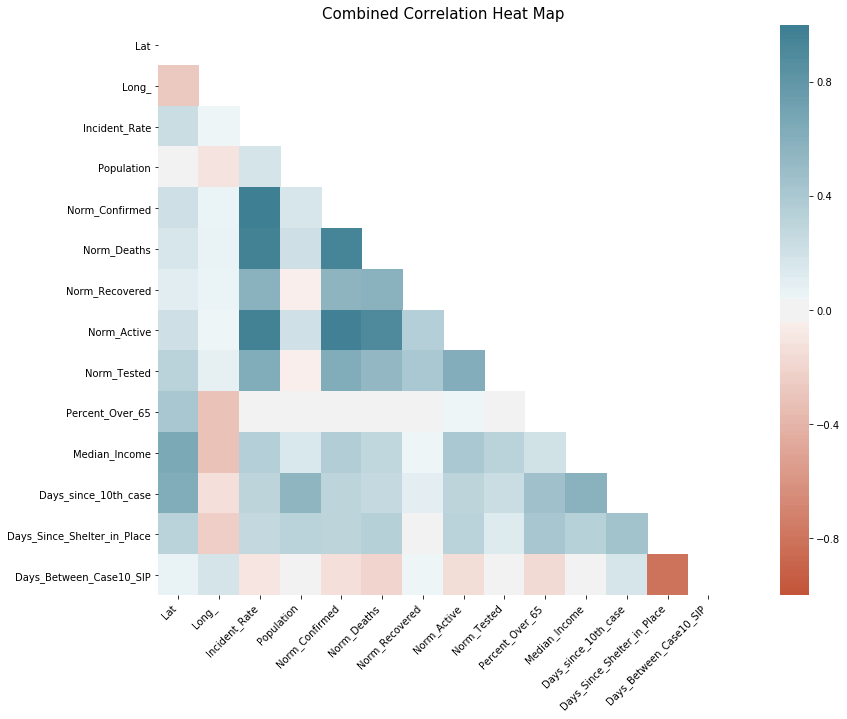

In [366]:
corr2 = df3.corr()

mask2 = np.zeros_like(corr2, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True

ax2 = sns.heatmap(
    corr2, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, mask=mask2
)
ax2.set_xticklabels(
    ax2.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Combined Correlation Heat Map', fontsize=15)
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# Incident Rate and Norm Active are too highly correlated with too many things, should drop 

Drop incident rate and norm_active since they are very highly correlated with other variables which might lead to multicollinearity. 

In [12]:
df3 = df3.drop(['Incident_Rate', 'Norm_Active'], axis = 1)

In [368]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, Alabama to Wyoming
Data columns (total 12 columns):
Lat                            56 non-null float64
Long_                          56 non-null float64
Population                     56 non-null float64
Norm_Confirmed                 56 non-null float64
Norm_Deaths                    56 non-null float64
Norm_Recovered                 56 non-null float64
Norm_Tested                    56 non-null float64
Percent_Over_65                56 non-null float64
Median_Income                  56 non-null float64
Days_since_10th_case           56 non-null float64
Days_Since_Shelter_in_Place    56 non-null float64
Days_Between_Case10_SIP        56 non-null float64
dtypes: float64(12)
memory usage: 5.7+ KB


Check for null values.

In [369]:
(df3.isnull().sum() / 56 * 100).round(2) # Percent of null values per column 

Lat                            0.0
Long_                          0.0
Population                     0.0
Norm_Confirmed                 0.0
Norm_Deaths                    0.0
Norm_Recovered                 0.0
Norm_Tested                    0.0
Percent_Over_65                0.0
Median_Income                  0.0
Days_since_10th_case           0.0
Days_Since_Shelter_in_Place    0.0
Days_Between_Case10_SIP        0.0
dtype: float64

#### Create test-train Split

In [370]:
# create the training and testing data sets
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4
np.random.seed(30)
mask = np.random.rand(len(df3)) < 0.7
df3_train = df3[mask]
df3_test = df3[~mask]
print('Training data set length='+str(len(df3_train)))
print('Testing data set length='+str(len(df3_test)))

Training data set length=42
Testing data set length=14


In [371]:
df3_train.head()

Lat     Long_  Population  Norm_Confirmed  Norm_Deaths  \
Province_State                                                               
Alabama         32.3182  -86.9023   4903185.0      160.875023     5.914523   
Alaska          61.3707 -152.4044    731545.0       50.304493     1.230273   
American Samoa -14.2710 -170.1320     55465.0        0.000000     0.000000   
Arizona         33.7298 -111.4312   7278717.0      118.702238     4.973404   
California      36.1162 -119.6816  39512223.0      138.951939     5.608391   

                Norm_Recovered  Norm_Tested  Percent_Over_65  Median_Income  \
Province_State                                                                
Alabama               0.000000  1886.528858             17.0        49396.0   
Alaska               35.814612  2949.647664             12.0        68400.0   
American Samoa        0.000000   102.767511              5.0        23892.0   
Arizona              21.940680  1114.468388             18.0        62311.0   
California            0.000000  1811.467302             14.0        70001.0   

                Days_since_10th_case  Days_Since_Shelter_in_Place  \
Province_State                                                      
Alabama                         49.0                         29.0   
Alaska                          44.0                         36.0   
American Samoa                   0.0                          0.0   
Arizona                         50.0                         33.0   
California                      72.0                         45.0   

                Days_Between_Case10_SIP  
Province_State                           
Alabama                            20.0  
Alaska                              8.0  
American Samoa                      0.0  
Arizona                            17.0  
California                         27.0

#### Begin with Poisson Regression

In [372]:
# Poisson 
# https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/

formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Norm_Recovered+Norm_Tested+Percent_Over_65+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place+Days_Between_Case10_SIP"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

# Log-Likelihood:                -121.72
# Deviance:                       79.459

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       31
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.72
Date:                Tue, 05 May 2020   Deviance:                       79.459
Time:                        15:43:52   Pearson chi2:                     84.1
No. Iterations:                     6   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.2032      0.635     -0.320      0.749      -1.448       1.042
L

In [373]:
# remove least significant variables one by one
# remove Percent_Over_65
formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Norm_Recovered+Norm_Tested+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place+Days_Between_Case10_SIP"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

# Log-Likelihood:                -121.73
# Deviance:                       79.490

# Log-Likelihood and deviance haven't really changed (both increase a tiny bit)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       32
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.73
Date:                Tue, 05 May 2020   Deviance:                       79.490
Time:                        15:43:54   Pearson chi2:                     84.0
No. Iterations:                     6   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.2467      0.588     -0.419      0.675      -1.400       0.907
L

In [374]:
# remove Days_Between_Case10_SIP
formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Norm_Recovered+Norm_Tested+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

# Log-Likelihood:                -121.73
# Deviance:                       79.490

# still no big change in log-likelihood or deviance

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       32
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.73
Date:                Tue, 05 May 2020   Deviance:                       79.490
Time:                        15:43:56   Pearson chi2:                     84.0
No. Iterations:                     6   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.2467      0.588     -0.419      0.675      -1.400       0.907
L

In [375]:
# remove Norm_Tested
formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Norm_Recovered+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

# Log-Likelihood:                -122.17
# Deviance:                       80.364

# log-likelihood and deviance are both starting to increase

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -122.17
Date:                Tue, 05 May 2020   Deviance:                       80.364
Time:                        15:43:58   Pearson chi2:                     83.5
No. Iterations:                     6   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.3323      0.600     -0.554      0.580      -1.509       0.844
L

In [376]:
# remove Long_
formula = """Norm_Deaths ~ Lat+Population+Norm_Confirmed+Norm_Recovered+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

# Log-Likelihood:                -123.91
# Deviance:                       83.854

# # log-likelihood and deviance are both starting to increase

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       34
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -123.91
Date:                Tue, 05 May 2020   Deviance:                       83.854
Time:                        15:44:00   Pearson chi2:                     87.9
No. Iterations:                     6   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.3264      0.540     -0.604      0.546      -1.385       0.732
L

In [377]:
# The above model seems good, but I'd like to cut it down to three or four variables so we're at less risk of overfitting
# remove Norm_Recovered, when I do this deviance shoots up, higher deviance means worse goodness of fit
formula = """Norm_Deaths ~ Lat+Population+Norm_Confirmed+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

# Log-Likelihood:                -126.04
# Deviance:                       88.099

# At this point deviance is starting to increase more sharply while log likelihood is only increasing a little, but I want fewer
# variable to avoid overfitting

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       35
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -126.04
Date:                Tue, 05 May 2020   Deviance:                       88.099
Time:                        15:44:02   Pearson chi2:                     91.7
No. Iterations:                     5   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1172      0.515     -0.228      0.820      -1.127       0.892
L

In [378]:
# remove Days_since_10th_case
formula = """Norm_Deaths ~ Lat+Population+Norm_Confirmed+Median_Income+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

# Log-Likelihood:                -129.32
# Deviance:                       94.658

# Deviance is increasing even more now, but I still have too many variables

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       36
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -129.32
Date:                Tue, 05 May 2020   Deviance:                       94.658
Time:                        15:44:05   Pearson chi2:                     95.1
No. Iterations:                     5   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.8439      0.267      3.163      0.002       0.321       1.367
L

In [379]:
# The above model seems good, but I'd like to cut it down to three or four variables so we're at less risk of overfitting
# remove Population
formula = """Norm_Deaths ~ Lat+Norm_Confirmed+Median_Income+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

# Log-Likelihood:                -132.66
# Deviance:                       101.34


# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
# https://www.medcalc.org/manual/chi-square-table.php

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       37
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -132.66
Date:                Tue, 05 May 2020   Deviance:                       101.34
Time:                        15:44:07   Pearson chi2:                     104.
No. Iterations:                     5   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.7699      0.268      2.871      0.004       0.244       1.295
L

Log-Likelihood:                -132.66
Deviance:                       101.34

Deviance and log-likelihood both increase. Higher log-likelihood indicates better goodness of fit, while higher deviance indicates worse goodness of fit.

At p=0.05 and DF Residuals = 37, the chi-squared value from a standard Chi-Squared table is 52.192 which is much smaller than the reported statistic of 101.34 and 104

The Poisson regression model has fit the training data poorly, perhaps due to the assumption that the variance is equal to the mean made by the Poisson model.

For every one degree increase in Latitude, the predicted log count of deaths per capita decreases by -0.0213, given the other predictor variables in the model are held constant. For every one unit increase in confirmed cases per capita, the predicted log count of deaths per capita increases by 0.0018, given the other predictor variables in the model are held constant. For every one dollar increase in median household income, the predicted log count of deaths per capita increases by 1.352e-05, given the other predictor variables in the model are held constant. For every one day increase in days since start of shelter in place, the predicted log count of deaths per capita increases by 0.0307, given the other predictor variables in the model are held constant.

In [380]:
# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
#expr = """Norm_Deaths ~ Lat+Population+Norm_Confirmed+Norm_Active+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""

In [381]:
y_train, X_train = dmatrices(formula, df3_train, return_type='dataframe')
y_test, X_test = dmatrices(formula, df3_test, return_type='dataframe')
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [383]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                     mean   mean_se  mean_ci_lower  mean_ci_upper
Province_State                                                   
Arkansas         2.453504  0.450944       1.711352       3.517501
Colorado        13.336432  0.820757      11.821011      15.046126
Hawaii          14.506829  2.824008       9.905381      21.245833
Idaho            7.531728  0.707635       6.264998       9.054580
Iowa             3.724989  0.739444       2.524374       5.496627
Maine            5.511356  0.547658       4.536024       6.696402
Michigan        14.187926  1.068526      12.240888      16.444660
Nevada           8.026898  0.480087       7.139004       9.025223
North Carolina   7.139140  0.534807       6.164257       8.268202
Tennessee        8.245834  0.540318       7.252013       9.375849
Texas            7.840074  0.570276       6.798372       9.041394
Virgin Islands   6.758251  0.946699       5.135677       8.893465
West Virginia    7.181253  0.713067       5.911254       8.724105
Wisconsin 

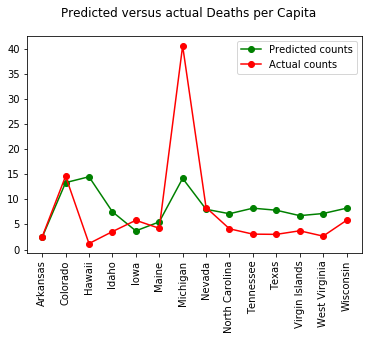

In [384]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Norm_Deaths']
fig = plt.figure()
fig.suptitle('Predicted versus actual Deaths per Capita')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.xticks(rotation=90)
plt.show()

While in general our model overestimates deaths per capita, it drastically underestimates deaths per capita in Michigan.
This could be because latitude is included in our model, which may be a proxy for compliance with shelter in place restrictions.
Politically, Michigan is largely protesting shelter in place, while other states at similar northern latitudes have been more compliant. 

https://abcnews.go.com/US/michigan-rally-shelter-place-order-spills-capitol-building/story?id=70432928

<Figure size 432x288 with 0 Axes>

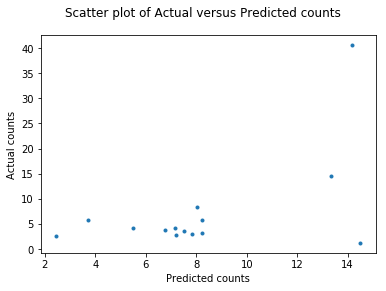

In [385]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

# https://stats.stackexchange.com/questions/104622/what-does-an-actual-vs-fitted-graph-tell-us

Ideally, all your points should be close to a regressed diagonal line. The weaker the Goodness of fit of your model, the more foggy or dispersed your points are (away from this diagonal line).
Our actual vs predicted graph shows that our points are highly dispersed, and our model has low goodness of fit.
In our graph, we are mostly overestimating the outcome (predicted > actual).

#### Using Poisson results, calculate alpha for negative binomial regression

Negative binomial regression can have an advantage over Poisson regression, as it does not assume that the variance is equal to the mean.

In [491]:
# https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/

import statsmodels.formula.api as smf

def ct_response(row):
    "Calculate response observation for Cameron-Trivedi dispersion test"
    y = row['Norm_Deaths']
    m = row['data_mu']
    return ((y - m)**2 - y) / m

ct_data = df3_train.copy()
ct_data['data_mu'] = po_results.mu
ct_data['ct_resp'] = ct_data.apply(ct_response, axis=1)
# Linear regression of auxiliary formula
ct_results = smf.ols('ct_resp ~ data_mu - 1', ct_data).fit()
# Construct confidence interval for alpha, the coefficient of bev_mu
alpha_ci95 = ct_results.conf_int(0.05).loc['data_mu']
print('\nC-T dispersion test: alpha = {:5.3f}, 95% CI = ({:5.3f}, {:5.3f})'
        .format(ct_results.params[0], alpha_ci95.loc[0], alpha_ci95.loc[1]))


C-T dispersion test: alpha = 0.047, 95% CI = (-0.005, 0.100)


In [492]:
# Negative Binomial
# https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/
formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Norm_Recovered+Norm_Tested+Percent_Over_65+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place+Days_Between_Case10_SIP"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -114.07
# Deviance:                       45.088

# https://www.medcalc.org/manual/chi-square-table.php
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       31
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -114.07
Date:                Wed, 06 May 2020   Deviance:                       45.088
Time:                        12:36:41   Pearson chi2:                     46.9
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1670      0.742     -0.225      0.822      -1.621       1.287
L

The Log-likelihood is lower than our initial Poisson model.
The value in the χ2 table for p=0.05 and Degrees of freedom of residuals=31 is 44.985. This is fairly similar to our observed statistics of Deviance (45.088) or the Pearson’s chi-squared value (46.9), demonstrating better goodness of fit than the  Poisson model. 

In [494]:
# remove least significant variable one by one
# remove Days_Between_Case10_SIP
formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Norm_Recovered+Norm_Tested+Percent_Over_65+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -114.07
# Deviance:                       45.088

# Very little change in log-likelihood or deviance.

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       31
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -114.07
Date:                Wed, 06 May 2020   Deviance:                       45.088
Time:                        12:37:43   Pearson chi2:                     46.9
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1670      0.742     -0.225      0.822      -1.621       1.287
L

In [495]:
# remove Norm_Tested
formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Norm_Recovered+Percent_Over_65+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -114.08
# Deviance:                       45.102

# Very little change in log-likelihood or deviance.

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       32
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -114.08
Date:                Wed, 06 May 2020   Deviance:                       45.102
Time:                        12:38:17   Pearson chi2:                     47.1
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1707      0.740     -0.231      0.818      -1.621       1.279
L

In [496]:
# remove Percent_Over_65
formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Norm_Recovered+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -114.09
# Deviance:                       45.117

# Very little change in log-likelihood or deviance.

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -114.09
Date:                Wed, 06 May 2020   Deviance:                       45.117
Time:                        12:39:27   Pearson chi2:                     47.1
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.2073      0.680     -0.305      0.760      -1.539       1.125
L

In [497]:
# remove Norm_Recovered
formula = """Norm_Deaths ~ Lat+Long_+Population+Norm_Confirmed+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -114.50
# Deviance:                       45.947

# Very little change in log-likelihood or deviance.

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       34
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -114.50
Date:                Wed, 06 May 2020   Deviance:                       45.947
Time:                        12:40:33   Pearson chi2:                     48.2
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1343      0.660     -0.203      0.839      -1.429       1.160
L

In [498]:
# remove Long_
formula = """Norm_Deaths ~ Lat+Population+Norm_Confirmed+Median_Income+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -115.48
# Deviance:                       47.895

# Slight increase in log-likelihood and deviance

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       35
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -115.48
Date:                Wed, 06 May 2020   Deviance:                       47.895
Time:                        12:41:34   Pearson chi2:                     50.0
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1715      0.607     -0.282      0.778      -1.362       1.019
L

In [503]:
# remove Median_Income
formula = """Norm_Deaths ~ Lat+Population+Norm_Confirmed+Days_since_10th_case+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())
# this is a good stopping point, but lets see how low we can go

# Log-Likelihood:                -116.90
# Deviance:                       50.732

# Slight increase in log-likelihood and deviance

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -116.90
Date:                Wed, 06 May 2020   Deviance:                       50.732
Time:                        12:48:21   Pearson chi2:                     51.7
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0599      0.637     -0.094      0.925      -1.309       1.189
L

In [504]:
y_train, X_train = dmatrices(formula, df3_train, return_type='dataframe')
y_test, X_test = dmatrices(formula, df3_test, return_type='dataframe')
nb_results1 = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=0.047)).fit()

In [505]:
nb_predictions1 = nb_results1.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
nb_predictions_summary_frame1 = nb_predictions1.summary_frame()
print(nb_predictions_summary_frame1)

                     mean   mean_se  mean_ci_lower  mean_ci_upper
Province_State                                                   
Arkansas         3.150191  0.665154       2.082610       4.765031
Colorado        12.376028  1.043565      10.490754      14.600102
Hawaii           9.913834  2.018382       6.651865      14.775421
Idaho            6.553830  0.981491       4.886755       8.789614
Iowa             4.379627  1.033765       2.757529       6.955915
Maine            5.575845  0.632313       4.464600       6.963679
Michigan        12.776193  1.458316      10.215098      15.979397
Nevada           8.601211  0.762592       7.229216      10.233590
North Carolina   6.527196  0.616856       5.423548       7.855428
Tennessee        8.490500  0.663873       7.284131       9.896663
Texas            4.091611  1.031091       2.496839       6.704991
Virgin Islands   6.937102  1.342785       4.746950      10.137748
West Virginia    6.373485  0.970533       4.728885       8.590039
Wisconsin 

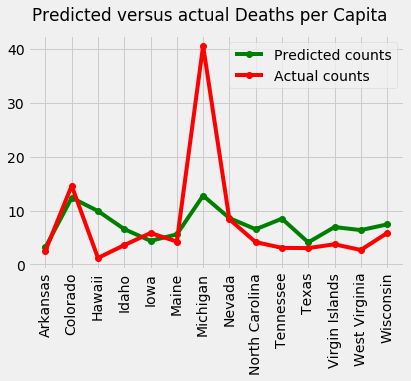

In [506]:
predicted_counts=nb_predictions_summary_frame1['mean']
actual_counts = y_test['Norm_Deaths']
fig = plt.figure()
fig.suptitle('Predicted versus actual Deaths per Capita')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.xticks(rotation=90)
plt.show() 

This predicted data fits better than the Poisson regression predictions. We are still overestimating deaths per capita and vastly underestimating Michigan, but overall this predicts better than Poisson regression.

<Figure size 432x288 with 0 Axes>

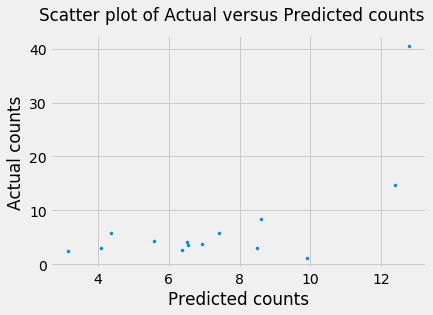

In [507]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()


Our actual vs predicted graph shows that our points are highly dispersed, and our model has low goodness of fit.
In our graph, we are mostly overestimating the outcome (predicted > actual). <br><br>
We still have too many predictors for such a small dataset (ideally at least 10 observations per predictor), so I attempt to reduce the number of predictors further.

In [500]:
# remove Days_since_10th_case
formula = """Norm_Deaths ~ Lat+Population+Norm_Confirmed+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -119.32
# Deviance:                       55.578

# Increased log-likelihood and deviance

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       37
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -119.32
Date:                Wed, 06 May 2020   Deviance:                       55.578
Time:                        12:43:40   Pearson chi2:                     53.3
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.0258      0.292      3.510      0.000       0.453       1.599
L

In [501]:
# remove Lat
formula = """Norm_Deaths ~ Population+Norm_Confirmed+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -119.76
# Deviance:                       56.458

# Slight increase in log-likelihood and deviance

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       38
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -119.76
Date:                Wed, 06 May 2020   Deviance:                       56.458
Time:                        12:44:48   Pearson chi2:                     54.2
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.7983      0.190      4.197      0.000       0.426       1.171
P

In [508]:
# remove Population
formula = """Norm_Deaths ~ Norm_Confirmed+Days_Since_Shelter_in_Place"""
response, predictors = dmatrices(formula, df3_train, return_type='dataframe')
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial(alpha=0.047)).fit()
print(nb_results.summary())

# Log-Likelihood:                -120.52
# Deviance:                       57.97

# Slight increase in log-likelihood and deviance
# Log-likelihood is lower than final Poisson model, but deviance is lower. 

# Poisson model:
# Log-Likelihood:                -132.66
# Deviance:                       101.34

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Norm_Deaths   No. Observations:                   42
Model:                            GLM   Df Residuals:                       39
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -120.52
Date:                Wed, 06 May 2020   Deviance:                       57.974
Time:                        12:53:11   Pearson chi2:                     56.3
No. Iterations:                     8   Covariance Type:             nonrobust
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.7960      0.189      4.209      0.000       0.425       1.167
N

Log-likelihood is lower than final Poisson model, but deviance is lower, which is desirable. 

Negative Binomial model:<br>
Log-Likelihood:                -120.52<br>
Deviance:                       57.97

Poisson model:<br>
Log-Likelihood:                -132.66<br>
Deviance:                       101.34

The value in the χ2 table for p=0.05 and Degrees of freedom of residuals=39 is 54.572. This is fairly similar to our observed
statistics of Deviance (57.974) or the Pearson’s chi-squared value (56.3), demonstrating better goodness of fit than the Poisson model. 

For a one unit change in the confirmed cases per capita, the difference in the logs of expected counts of deaths per capita
is expected to increase by 0.0021, given the other predictor variables in the model are held constant.

For a one day change in the days since initation of shelter in place, the difference in the logs of expected counts of 
 deaths per capita is expected to increase by 0.0266, given the other predictor variables in the model are held constant.

In [509]:
y_train, X_train = dmatrices(formula, df3_train, return_type='dataframe')
y_test, X_test = dmatrices(formula, df3_test, return_type='dataframe')
nb_results2 = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=0.047)).fit()

In [510]:
nb_predictions2 = nb_results2.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
nb_predictions_summary_frame2 = nb_predictions2.summary_frame()
print(nb_predictions_summary_frame2)

                     mean   mean_se  mean_ci_lower  mean_ci_upper
Province_State                                                   
Arkansas         2.815032  0.535948       1.938317       4.088291
Colorado        11.171464  0.821240       9.672445      12.902797
Hawaii           6.860582  0.674659       5.657898       8.318918
Idaho            7.971606  0.727151       6.666552       9.532140
Iowa             4.080185  0.794508       2.785677       5.976251
Maine            6.085896  0.486026       5.204112       7.117088
Michigan        16.130480  1.129154      14.062486      18.502588
Nevada           7.541019  0.550147       6.536293       8.700187
North Carolina   6.933090  0.556473       5.923884       8.114226
Tennessee        7.997001  0.578643       6.939631       9.215479
Texas            6.376034  0.497308       5.472173       7.429188
Virgin Islands   5.606049  0.459656       4.773803       6.583386
West Virginia    7.392238  0.732815       6.086867       8.977556
Wisconsin 

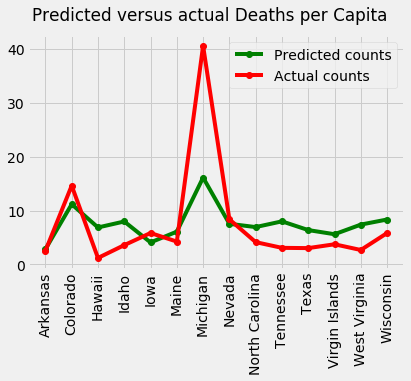

In [511]:
predicted_counts=nb_predictions_summary_frame2['mean']
actual_counts = y_test['Norm_Deaths']
fig = plt.figure()
fig.suptitle('Predicted versus actual Deaths per Capita')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.xticks(rotation=90)
plt.show()

This predicted data fits better than the Poisson regression predictions. We are still overestimating deaths per capita and vastly underestimating the outlier Michigan.

<Figure size 432x288 with 0 Axes>

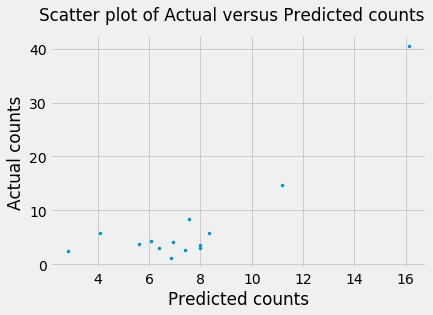

In [512]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

Our actual vs predicted graph shows that our points are still dispersed, but less so than in our previous regression models.
Dispersion indicates low goodness of fit. In our graph, we are mostly overestimating the outcome (predicted > actual).

## SVR

In [13]:
from sklearn.metrics import r2_score,mean_squared_error

In [21]:
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import random

In [15]:
# https://pythonprogramming.net/training-testing-machine-learning-tutorial/
X = np.array(df3.drop(['Norm_Deaths'], 1))
y = np.array(df3['Norm_Deaths'])

### Split into test and train

In [159]:
random.seed(9)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

Scale after spliting into test-train

In [160]:
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [161]:
clf = svm.SVR()

In [162]:
clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [163]:
confidence = clf.score(X_test, y_test)
print(confidence)
# Return the coefficient of determination R^2 of the prediction.
# The best possible score is 1.0 and it can be negative
# -0.05272237089384646
# A negative score indicates that this model is performing poorly

-0.05272237089384646


Return the coefficient of determination R^2 of the prediction.The best possible score is 1.0 and it can be negative

This negative score indicates that our model is performing poorly.

In [164]:
# https://heartbeat.fritz.ai/support-vector-regression-in-python-using-scikit-learn-89cc18e933b7
y_pred = clf.predict(X_test)

In [165]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
# 275.5978241634115

from sklearn.metrics import mean_absolute_error
amse = mean_absolute_error(y_test, y_pred)
print("Absolute Mean Squared Error:", amse)

Mean Squared Error: 606.2274858009212
Root Mean Squared Error: 24.621687306131584
Absolute Mean Squared Error: 10.633778273298082


<Figure size 432x288 with 0 Axes>

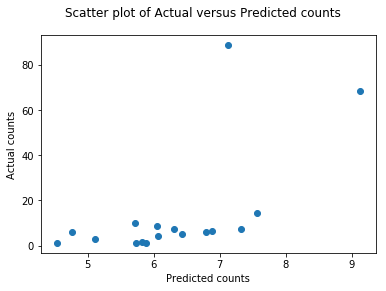

In [166]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=y_pred, y=y_test)
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

Values dispersion is similar to the results from poisson and negative binomial regression, indicating similar goodness of fit.
We seem to be underestimating the deaths per capita with this model, as predicted counts are consistenly lower than actual.

In [167]:
clf = LinearRegression()

In [168]:
clf = LinearRegression(n_jobs=-1)

In [169]:
for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("kernel:", k, " Confidence: ", confidence, " MSE: ", mse)

kernel: linear  Confidence:  0.7506082495621007  MSE:  143.6163399083915
kernel: poly  Confidence:  0.3561055508637616  MSE:  370.7972052399676
kernel: rbf  Confidence:  -0.05272237089384646  MSE:  606.2274858009212
kernel: sigmoid  Confidence:  0.14110999021590953  MSE:  494.6059337267013


Linear kernel gives best results, with the highest R2 score and lowest mean squared error

### Linear kernel parameter tuning - C and gamma

In [178]:
C_range = 10.0 ** np.arange(-2, 4)
param_grid = dict(C=C_range)
param_grid

{'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [179]:
# Default is 3-fold cross validation
grid = GridSearchCV(svm.SVR(kernel='linear',cache_size=1000), param_grid=param_grid) 
grid.fit(X_train, y_train)# run the grid search on the training data only
best_C = grid.best_estimator_.C
print ("The best C for linear is: %.5f " % (best_C))
grid.best_estimator_

The best C for linear is: 10.00000 


SVR(C=10.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [180]:
svr3 = svm.SVR(kernel='linear', C=10) 
clf = svr3.fit(X_train, y_train) # trains the classifier on the training set
confidence = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Confidence: ", confidence) # now we're at 72% accuracy
print("MSE: ", mse)

Confidence:  0.9381215238609308
MSE:  35.63373787063072


MSE has decreased from our original svr model, and R2 score has increased dramatically, indicating much better goodness of fit.
Our model explains 93% of the variance in deaths per capita.

In [183]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
# 275.5978241634115

amse = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", amse)

Mean Squared Error: 35.63373787063072
Root Mean Squared Error: 5.969400126531201
Mean Absolute Error: 4.336629721034587


Absolute Mean Error is 4, which is much better than the AME for the previous rbf model

<Figure size 432x288 with 0 Axes>

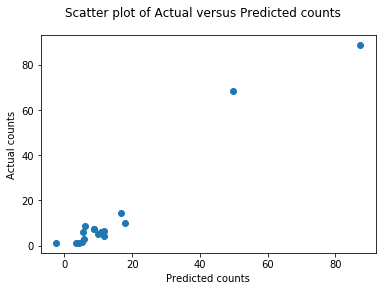

In [182]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=y_pred, y=y_test)
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

Values are less dispersed than for poisson and negative binomial regression, indicating better goodness of fit.

## Random Forest

In [457]:
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
labels = np.array(df3['Norm_Deaths'])

# Remove the labels from the features
# axis 1 refers to the columns
features= df3.drop('Norm_Deaths', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [459]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 42)

In [460]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (39, 11)
Training Labels Shape: (39,)
Testing Features Shape: (17, 11)
Testing Labels Shape: (17,)


In [464]:
feature_list

['Lat',
 'Long_',
 'Population',
 'Norm_Confirmed',
 'Norm_Recovered',
 'Norm_Tested',
 'Percent_Over_65',
 'Median_Income',
 'Days_since_10th_case',
 'Days_Since_Shelter_in_Place',
 'Days_Between_Case10_SIP']

In [465]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

C:\Users\jstot\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [468]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 6.76


Mean absolue error is higher than in our linear kernel SVR model, indicating SVR might be the best model of all for this data.

In [469]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 59.06 %.


In [472]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Norm_Confirmed       Importance: 0.79
Variable: Norm_Recovered       Importance: 0.06
Variable: Norm_Tested          Importance: 0.03
Variable: Long_                Importance: 0.02
Variable: Population           Importance: 0.02
Variable: Median_Income        Importance: 0.02
Variable: Days_Since_Shelter_in_Place Importance: 0.02
Variable: Lat                  Importance: 0.01
Variable: Days_since_10th_case Importance: 0.01
Variable: Days_Between_Case10_SIP Importance: 0.01
Variable: Percent_Over_65      Importance: 0.0


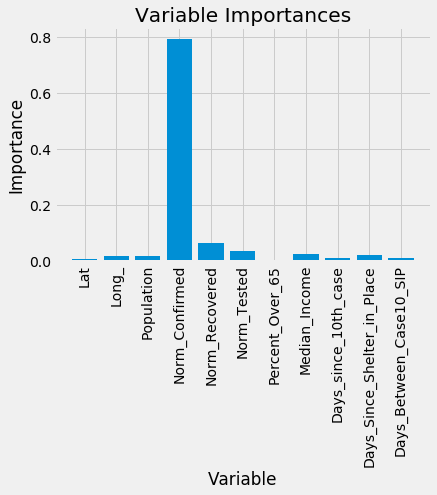

In [477]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Confirmed cases per capita is by far the most important predictor of deaths per capita, which is unsurprising.
This was also an important variable in all of our regression models.

In [476]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('Norm_Confirmed'), feature_list.index('Norm_Recovered')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 5.61
Accuracy: 59.06 %.


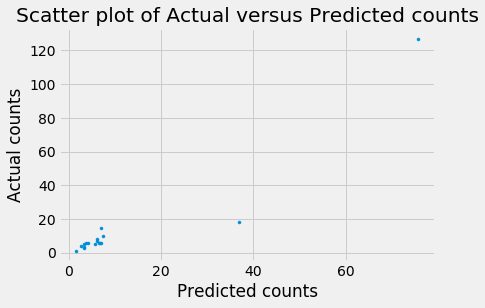

In [479]:
plt.scatter(x=predictions, y=test_labels, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.title('Scatter plot of Actual versus Predicted counts')
plt.show()

It looks like we are slightly underestimating deaths per capita, as predicted counts are consistently lower than actual counts.
Dispersion is not too bad, indicating ok goodness of fit.

When we reduce our numer of predictors accuracy stays constant, while mean absolute error decreases. This indicates that
most of our predictors may not be helpful in our model. Mean absolute error is slightly higher than in our best svr model,
leading us to choose the tuned svr model with linear kernel as the best model for this dataset.